# World Data League 2021

## Notebook Template

This notebook is one of the mandatory deliverables when submitting solution. Its structure follows the WDL format criteria.

The notebook:

- 💻 have all the code for the jury to evaluate

- 🧱 follow the predefined structure

- 📄 have markdown descriptions 

- 👀 saved with all the output we want the jury to see

- 🏃‍♂️ is runnable

## Introduction

This is team Old Walruses response to WDL competition Stage 3 challenge **"Predicting the demand for shared bicycles".**

The goal of the challenge is “to make system load balancing decisions based on demand forecasting based on historical data. Load balancing means the planning of transporting bicycles from one station to another”.

A complete load balancing planning would include the following steps:

1.	Forecasting the demand;

2.	Exploring route options between station, and assigning weights to each route (in order to allow an algorithm to select fastest route, cheapest route,…). Probably this route weight should change over time, as actual road constructions, restrictions and traffic impacts which is the fastest / cheapest route on any given time (the same way Google suggests different routes between the same 2 points, depending on the current situation).

3.	Based on actual stock and demand (calculated in step 1.), and available route alternatives (calculated in step 2.) working out the logistic details, i.e. define how many bikes should be transported from particular station(s) to other particular station(s) on which routs in order to optimize transport. In addition to the outcome of 1. and 2., such optimization algorithm should also take into account the number of trucks used in transportation, the location of common bike stores, etc. 

Step 1. is a data science (ML) forecasting task, step 2. is spatial data analytics, while step 3 is an optimization task.

The title and goal description of this challenge suggested that scope here is to forecast the demand, i.e. step 1. This is what we implemented and the next sections explain our solution.

Demand in this context can mean various things, e.g. number of rented bikes, number of minutes bikes are rented, etc. We defined demand as the number of bikes needed to be installed at the morning in order to fulfil all requests. This special definition takes into account the bike rent / returns dynamics during the day, and in our understanding this is what really matters to the service operators.

One important finding is that stations were coming and going in the past, and one could assume similar dynamics for the future as well. The impact on the exercise is twofold: 

- On the one hand, we had no "stable" historical data on network level. For "old" stations we may have it (conditional tense is used here because even though if we have long data for the particular station, new stations in the nearby obviously impacted this station's pattern, too.)

- A solution worked out today for today's network will have short life-cycle. What could be value is the method developed, which has to be updated time and again as the station network is changing. Hence, our ambition here was to develop a method (framework) that can be applied "any time".

# Development

## Working Process

We followed the following process (with quite a bit of iteration):

1.	Understanding the data (EDA) that is provided by WDL

2.	Based on data and high-level problem description (“demand forecast”) shaped data and refined the objective of the exercise

3.	Created a demand forecast model.

For the work we also read up articles publicly available on the internet on Medellín’s City Bike system.


## Understanding Data (EDA)

### Initial Basics

Load data and libraries, drop columns that are marked “not applicable” in the WDL provided data dictionary, rename columns from Spanish, do some basic conversion.

In [1]:
library(data.table)
library(ggplot2); theme_set(theme_bw())
library(lubridate)
library(sf)
library(fs)
library(magrittr)
library(leaflet)
library(tidyverse)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'lubridate'

The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following object is masked from 'package:base':

    date

Warning message:
"package 'sf' was built under R version 3.6.3"Linking to GEOS 3.9.0, GDAL 3.2.1, PROJ 7.2.1
Warning message:
"package 'leaflet' was built under R version 3.6.3"Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v tibble  3.0.1     v purrr   0.3.2
v tidyr   1.1.0     v dplyr   0.8.5
v readr   1.3.1     v stringr 1.4.0
v tibble  3.0.1     v forcats 0.4.0
Warning message:
"package 'tibble' was built under R version 3.6.3"Warning message:
"package 'tidyr' was built under R ve

In [2]:
# read unzipped csv 
dt <- fread ("C:/bd/bd_Rprojs/20210402_WDL/Section3/Data/bike_loans.csv")

# get rid of "not applicable" columns
dt <- dt %>% select (-c(DescripcionImporte, Importe, Num_Bici_Hist)) %>% data.table()

# rename columns from Spanish for better understanding
old_names <- colnames (dt)
new_names <- c("IDRent", "IDUser", "IDBike", "TimeStart", "TimeStop", "IDStationOrig", "PosOrig", "IDStationDest", "PosDest", "Oper")
dt <- dt %>% rename_at(vars(old_names), ~ new_names) 

# make sure that these fields are chr (some R reads them chr, some datetime and int)
dt <- dt %>% 
   mutate (TimeStart = as.character(TimeStart)) %>%
   mutate (TimeStop = as.character (TimeStop)) %>%
   mutate (IDRent = as.character (IDRent), IDBike = as.character (IDBike), IDUser = as.character (IDUser) ) %>%
   mutate (IDStationOrig = as.character (IDStationOrig), IDStationDest = as.character (IDStationDest)) %>%
   mutate (IDStationDest = as.character (IDStationDest)) %>%
   data.table()

Note: Using an external vector in selections is ambiguous.
i Use `all_of(old_names)` instead of `old_names` to silence this message.
i See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


### Rental Distribution

### Rental Trends

In [3]:
### Distribution of number of rents (year: start of the rental) by year

dt %>%
  group_by(year(TimeStart)) %>%
  summarize (yearlyRents = n())

year(TimeStart),yearlyRents
2014,210880
2015,1161752
2016,1512599
2017,2289945
2018,2793375
2019,3798179
2020,1901283
2021,557342


`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


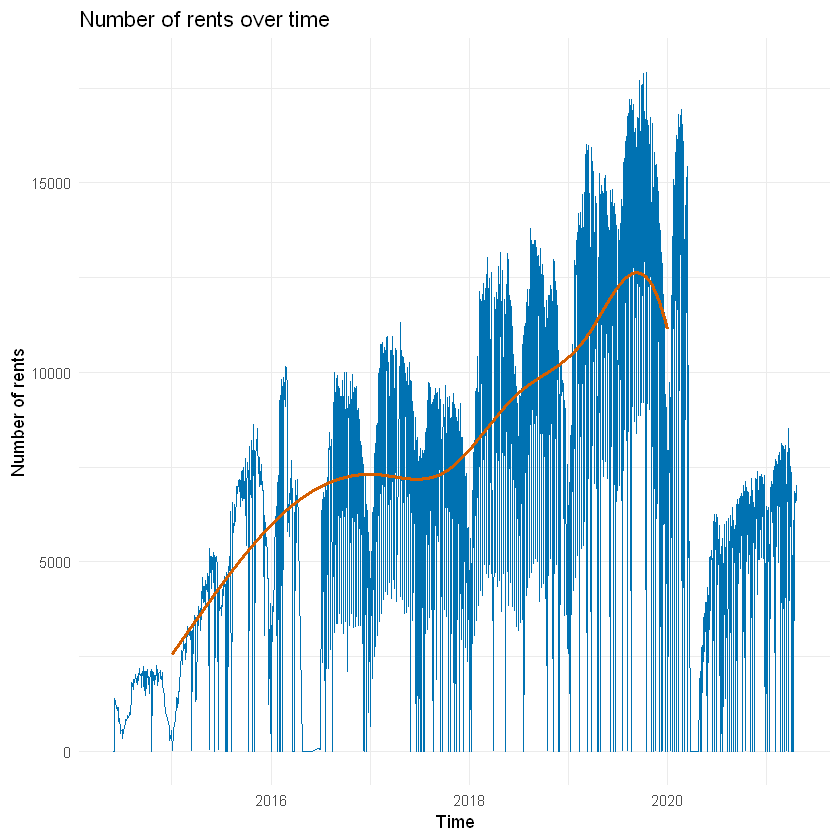

In [4]:
### Number of rents over time with trendline from 2015 until Eo 2019 (before: half year, after: COVID)

dt %>%
  mutate (date = as.Date (TimeStart)) %>%
  group_by (date) %>%
  summarize (Rents = n()) %>%
  ggplot (aes(date, Rents, group=1)) + geom_line(color = "#0072B2") + 
  stat_smooth(xseq = as.Date("2015-01-01"):as.Date("2020-01-01"), se= FALSE, color = "#D55E00") + 
  labs (x = "Time", y = "Number of rents", title = "Number of rents over time") +
  theme_minimal() 

There are interesting negative spikes in the plot (cases when there were a few rents, but only very few). 

Below table explains part of the story:

In [5]:
### Negative spikes (not 0 but close to 0 rents) in 2019: dates, number of rents, day of week (0: Sunday, 6: Saturday)

dt %>%
  mutate (date = as.Date (TimeStart)) %>%
  group_by (date) %>%
  summarize (Loans = n())  %>%
  filter (Loans < 100) %>%
  # look at only 2019 for now
  filter (year(date) == "2019") %>%
  mutate (day_of_wk = as.POSIXlt(date)$wday) %>%
  data.table()

date,Loans,day_of_wk
2019-01-07,1,1
2019-02-10,11,0
2019-03-10,3,0
2019-03-25,12,1
2019-04-18,7,4
2019-04-20,13,6
2019-04-28,5,0
2019-06-03,2,1
2019-06-16,6,0
2019-06-23,6,0


Comparing these dates of negative spikes to calendar and list of public holidays in Colombia in 2019 reveals that majority of such cases occurred on dates when the stations were closed (Sunday, public holidays). Probably a few stations rented out bike on these days to their "VIP"s. So these spikes are not considered errors.

**Conclusion:**

- 2014 and 2021 are incomplete years

- Negative spikes: cases when some stations rented out some bikes in spite of date being legal holiday

- Dynamic YoY growth btw. 2015 and 2019

- Seasonality

- Massive drop in 2020 is likely due to COVID. It is unknown (as anywhere else) how habits and trends will change post COVID.




## Rental Duration - checking date / time variables

Purpose:

- Sanity check, i.e. checking if rent transactions end time is is later than start time

- Validating publicly available (internet) statement about bike rental time (said to be incentivized not to exceed 1 hour).

In [6]:
### cases where the abs. difference between bike return and bike rent time is more than 1 day
### shown by year >1 day rent occurred (started): number of such rents, number of stations w. long rent start; avg length of long renths; 
dt %>%
  mutate (PxTimeStart = as.POSIXct(TimeStart, format = "%Y-%m-%d %H:%M:%S", tz="UTC")) %>%
  mutate (PxTimeStop = as.POSIXct(TimeStop, format = "%Y-%m-%d %H:%M:%S", tz="UTC")) %>%
  mutate (length = difftime(PxTimeStop, PxTimeStart, units = "days")) %>%
  mutate (length = as.numeric(length)) %>%
  filter (abs(length) > 1) %>%
  group_by (Year_rent_start = substr(TimeStart,1,4)) %>%
  summarise (Number_of_Stations_effected = uniqueN(IDStationOrig), avg_days=mean(length), number_of_cases = n()) 

Year_rent_start,Number_of_Stations_effected,avg_days,number_of_cases
2014,17,773.47316,387
2015,49,16.11121,582
2016,57,-478.73767,933
2017,56,-535.75445,924
2018,48,-414.01544,195
2019,54,-92.92271,473
2020,85,-706.96542,386
2021,49,-946.72857,96


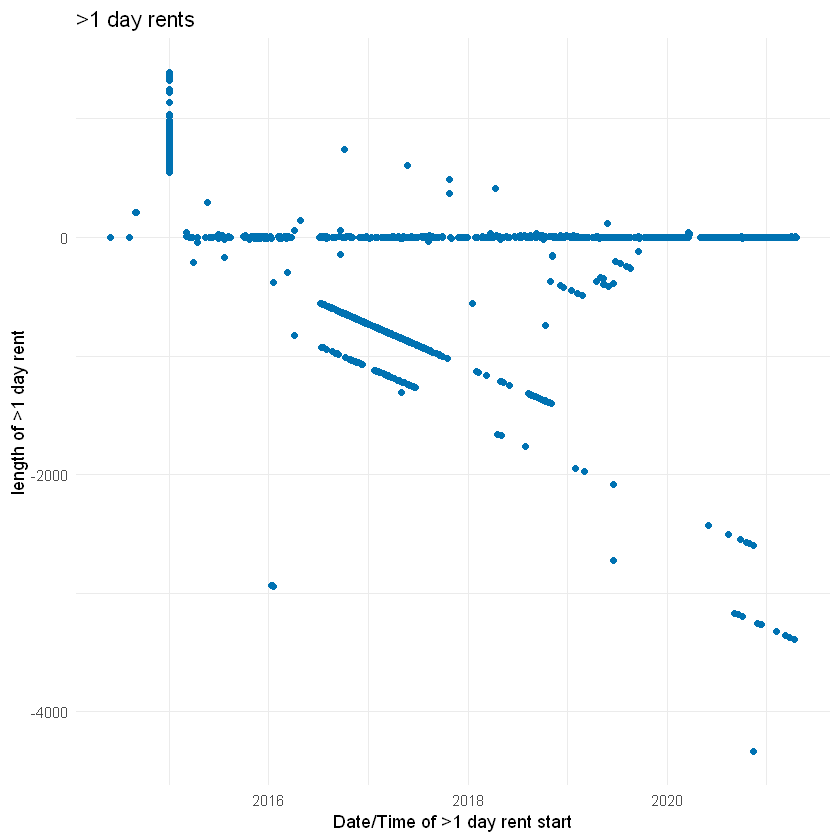

In [7]:
### plot: >1 day rents: rent start date/time on x, duration on y

dt %>%
  mutate (PxTimeStart = as.POSIXct(TimeStart, format = "%Y-%m-%d %H:%M:%S", tz="UTC")) %>%
  mutate (PxTimeStop = as.POSIXct(TimeStop, format = "%Y-%m-%d %H:%M:%S", tz="UTC")) %>%
  mutate (length = difftime(PxTimeStop, PxTimeStart, units = "days")) %>%
  mutate (length = as.numeric(length)) %>%
  filter (abs(length) > 1) %>%
  ggplot (aes(PxTimeStart, length)) + geom_point(color = "#0072B2") + theme_minimal() +
  labs (x = "Date/Time of >1 day rent start", y = "length of >1 day rent", title = ">1 day rents")

Above table and plot show some negative rent durations, the linearity in the plot suggests that there were some "popular" dates in the past that frequently were used in bike return back dates.

In [8]:
data.table(dt) [,min(TimeStart)]

[1] "2014-05-30 15:41:33.000"

In [9]:
### Earliest rental start and return dates in the table
cat ("Earliest start date in table is:")
print (dt[,min(TimeStart)])
cat ("\n Earliest return date is:")
print (dt[,min(TimeStop)])

Earliest start date in table is:[1] "2014-05-30 15:41:33.000"

 Earliest return date is:[1] "2008-01-01 00:04:01.000"


**Conclusion:**

- Number of cases when return date is set earlier than rent start date, some are even before first rental date in data collection.

- Comparing to the data volume, this is fraction of a percentage. It does not seem to relate to particular station(s) nor to particular year(s). Look like random errors.

- The number of such cases is still low compared to the number of data points => these observations are to be dropped.

## Stations - Location

In [10]:
data_stations <- fread ("https://raw.githubusercontent.com/bdtudos/WDL/main/station_location_with_id.csv")

data_stations <- data_stations %>% 
    mutate(Lat = as.numeric(str_replace(Lat, ",", "."))) %>%
    mutate(Lon = as.numeric(str_replace(Lon, ",", ".")))

projcrs <- "+proj=longlat +datum=WGS84"
df <- st_as_sf(x = data_stations,
               coords = c("Lon", "Lat"),
               crs = projcrs,
               agr = "identity")

pal <- colorFactor(c("blue", "red"), c(0,1))   # RColorBrewer::brewer.pal()
leaflet(data = df) %>% 
  addTiles() %>%
  addCircles(color = ~ pal(isManual), radius = 8) %>% 
  addLegend("bottomleft", pal = pal, values = ~isManual,
            title = "Station Type",
            opacity = 1)

HTML widgets cannot be represented in plain text (need html)

## Stations - Number of stations over time

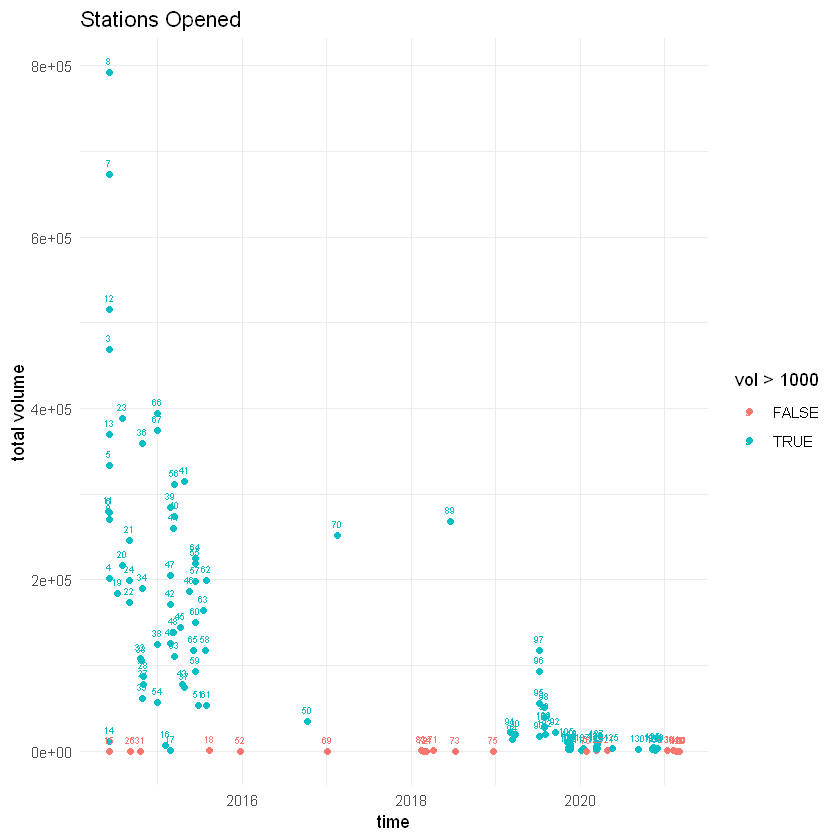

In [11]:
### plot: stations with first appearance (opened) after 2014-06-01, showing their total traffic on y
### measure of opening strategy success, on the left should be high
dt %>%
  group_by (IDStationOrig) %>%
  summarise (FirstAppeared = min(TimeStart), vol = n()) %>%
  filter (substr(FirstAppeared, 1,10) > "2014-06-01") %>%
  ggplot (aes(as.Date(FirstAppeared), vol, color = vol>1000, label = IDStationOrig)) + 
  geom_point() + geom_text(size=2, vjust = -1) + 
  labs (x = "time", y = "total volume", title = "Stations Opened") + 
  theme_minimal()

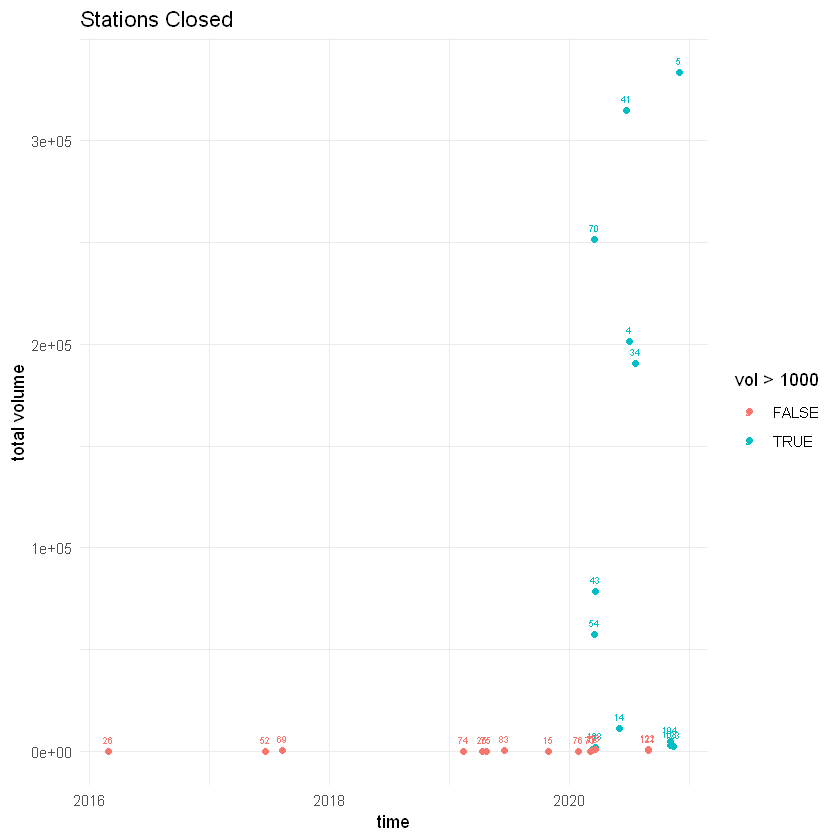

In [12]:
### plot: stations with last rent occurred before 2021 (likely closed), color marked by total rent volume
dt %>%
  group_by (IDStationOrig) %>%
  summarize (LastAppeared = max(TimeStart), vol = n()) %>%
  filter (substr(LastAppeared,1,4) < "2021") %>%
  ggplot (aes(as.Date(LastAppeared), vol, color = vol>1000, label = IDStationOrig)) + 
  geom_point() + geom_text(size=2, vjust = -1) + 
  labs (x = "time", y = "total volume", title = "Stations Closed") + 
  theme_minimal()

**Conclusion:**

- Few stations closed, mostly small ones but in 2020 also bigger ones. Easy excuse to the latter: COVID?

- Many stations opened along the years.

- These two above means that we are lacking stationarity here: For new stations we lack enough data. Also, commissioning a new station close to an old one surely will impact patterns in the old station. Finally, seeing that stations were coming and going in the past, one could assume similar dynamics for the future as well. The impact on the exercise is that a solution worked out today will have short life-cycle, what could be value is the method developed, which has to be updated time and again as the station network is changing.

## Stations - Load distribution

Looking at rent volume carried by stations, in order to see symmetry / assymetry, bot originated traffic (bike rent) and terminating traffic (bike returned) indicated. Year 2019 looked at.

In [13]:
### Function to summarize rent volumes (orig or dest, depending on type parameter) for stations per years, filter 2019

volume_startyear <- function (dt, type = orig, filter_years)
{
  IDColumn = ifelse (type == "dest", "IDStationDest", "IDStationOrig")
  TimeColumn = ifelse (type == "dest", "TimeStop", "TimeStart")
  
  dt %>%
    mutate (year = substr(get(TimeColumn),1,4)) %>%
    group_by_at (c(IDColumn, "year" )) %>%
    summarise(volume = n()) %>%
    filter (year %in% filter_years)
}

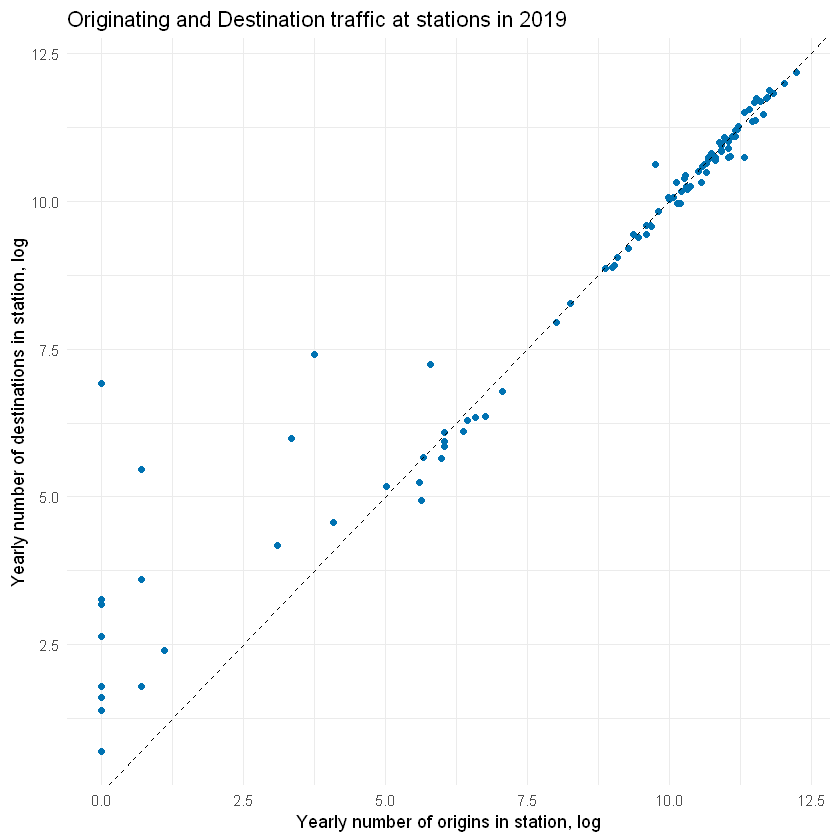

In [14]:
### Display X: 2019 originating traffic volume of station, y: 2019 terminating traffic volume of station
# first destination on purpose: 
volume_startyear(dt, "orig", "2019") %>%
  full_join (volume_startyear(dt, "dest", "2019"), by = c("IDStationOrig" = "IDStationDest", "year" = "year")) %>%
  # treat stations that appeared only as destination or only as origin
  mutate(volume.x = tidyr::replace_na(volume.x, 0)) %>%
  mutate(volume.y = tidyr::replace_na (volume.y, 0)) %>%
  ggplot (aes(log1p(volume.x), log1p(volume.y))) + geom_point(color = "#0072B2") + 
  geom_abline(intercept = 0, slope = 1, linetype = "dashed") + 
  labs (x = "Yearly number of origins in station, log", y = "Yearly number of destinations in station, log",
        title = "Originating and Destination traffic at stations in 2019") + theme_minimal()

There are some stations that are destination only. Are these real (return only points) or errors?

We assumed that data is correct, but as explained later, we decided to exclude them from the scope.

## Return only stations

In [15]:
# only origin stations
print(setdiff (dt[,unique(IDStationOrig)], dt[,unique(IDStationDest)]))
# only destinations
print(setdiff (dt[,unique(IDStationDest)], dt[,unique(IDStationOrig)]))

character(0)
 [1] "79"   "NULL" "82"   "0"    "84"   "80"   "77"   "86"   "88"   "85"  
[11] "87"   "120"  "81"   "150" 


"NULL" and "0" -by their name- look like consequence of missing return station administration, the rest might be real ones.

Validation of the above hypothis: looking at these destination only stations, and checking if there has been a Bike that was returned at any of such stations and then within extreme short (arbitrarily chosen 5 minutes) rented out at some other station. As it is unlikely to transport a bike from one station to another within 5 minute, this wold indicate some sort of administration error.

In [16]:
### Function to check if a bike returned at StationID has been rented out from a station MINS_int minutes later in year YEAR_strs

In_Out_Check <- function (StationID, MINS_int = 5, YEAR_strs)
# Checks if any bike returned to StationID at any time is originated from a station within the next MINS minute
{
  dt %>% filter (IDStationDest==StationID) %>% 
    # keep only specified years
    filter (substr(TimeStop,1,4) %in% YEAR_strs) %>%
    # Window to check if rented elsewhere is from handback time (TimeStop) to handback time + MINS_int minutes
    mutate (WindowStart = as.POSIXct(TimeStop,format = "%Y-%m-%d %H:%M:%S", tz = "UTC")) %>%
    mutate (WindowStop = WindowStart + 1*MINS_int*60) %>%
    select (WindowStart, WindowStop, IDBike) %>%
    # log the station: needed when binded result of multiple function calls in lapply
    mutate (CheckedStation = StationID) %>%
    # filter original data to bike returned at these stations
    left_join (dt, by = c("IDBike" = "IDBike")) %>%
    # filter those transactions on these bikes that happenned during time window
    filter (as.POSIXct(TimeStart,format = "%Y-%m-%d %H:%M:%S", tz = "UTC") > WindowStart) %>%
    filter (as.POSIXct(TimeStart,format = "%Y-%m-%d %H:%M:%S", tz = "UTC") < WindowStop)
}

In [17]:
### call above function for all stations that are destinations only in 2018-2020, collect result in one matrix
do.call(rbind, 
        lapply ( setdiff (dt[,unique(IDStationDest)], dt[,unique(IDStationOrig)]), 
                 function(x) In_Out_Check(x,5, c("2018", "2019", "2020"))) ) %>%
  select (IDBike, CheckedStation, WindowStart, WindowStop, IDStationOrig, TimeStart)

IDBike,CheckedStation,WindowStart,WindowStop,IDStationOrig,TimeStart
000017AFC891,NULL,2018-07-12 17:21:05,2018-07-12 17:26:05,83,2018-07-12 17:21:49.000
SA370,NULL,2018-07-31 15:34:57,2018-07-31 15:39:57,25,2018-07-31 15:35:40.000
SA18,NULL,2018-08-02 16:04:41,2018-08-02 16:09:41,25,2018-08-02 16:05:04.000
000017A71482,NULL,2018-08-03 17:46:04,2018-08-03 17:51:04,83,2018-08-03 17:46:43.000
000017A71482,NULL,2018-08-03 18:10:21,2018-08-03 18:15:21,83,2018-08-03 18:11:03.000
0000190C82FD,NULL,2018-08-09 19:51:44,2018-08-09 19:56:44,83,2018-08-09 19:52:17.000
0000190C9CC4,NULL,2018-08-22 07:37:09,2018-08-22 07:42:09,83,2018-08-22 07:38:10.000
0000164B9F33,NULL,2018-08-23 16:18:10,2018-08-23 16:23:10,83,2018-08-23 16:18:47.000
000017AFFDA1,NULL,2018-08-22 18:57:01,2018-08-22 19:02:01,83,2018-08-22 18:57:28.000
0000190B1BBC,NULL,2018-08-27 18:27:05,2018-08-27 18:32:05,83,2018-08-27 18:28:55.000


**Conclusions:**

- There are two destination-only stations with cases of bike handed in and then within 5 minutes (sometimes even within 1 minute) the same bike rented out from another station. These are stations "NULL" and "0" (see CheckedStation), the latter only in 2020. Example: first row item, where a bike was handed in to Station NULL on 2018-07-12 at 17:21:05 (WindowStart), and then rented 30 seconds later (TimeStart) from station 83.

- The next stations (i.e. where the bike was rented from within 5 minutes, column IDStationOrig) vary, so it is likely that "NULL" and "0" stations are destination data where the destination ID was not filled in.

- In number these are not very many, we can ignore it.

## Stations with highest load

It was shown earlier that there are a few number of stations with very high load, and there is a long tail with lower load. Worth to look at which stations "matter" most, i.e. take highest traffic.

A definition of "matter most" is as follows: station that carried significant Originating and Terimnating traffic in 2017, 2018, 2019.

Errorneous data (i.e. where bike return occurred before bike rental) is dropped. When filtering to years, only those transactions are included where both rent and return occurred the same day.

The plot shows 2017 traffic on x, 2019 traffic on y, and 2018 traffic as size, facetted by type of transaction (station was the origin or destination of bike rental, though as seen before at the right of the originating - destination traffic plot, these should be pretty much the same).


Warning message:
"Removed 80 rows containing missing values (geom_point)."Warning message:
"Removed 77 rows containing missing values (geom_text)."

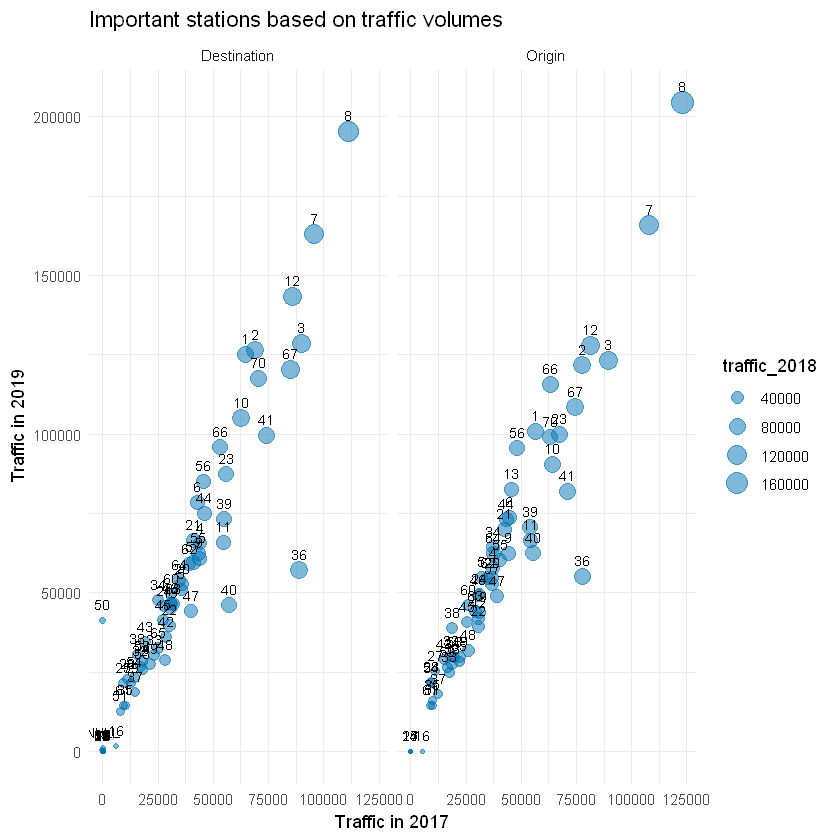

In [18]:
YEARS <- c("2017", "2018", "2019")

### filter to years (both ends of transaction)
filtered <- dt %>%
  # drop junks
  filter (TimeStart < TimeStop) %>%
  filter (substr (TimeStart,1,4) %in% YEARS) %>%
  filter (substr (TimeStop,1,4) %in% YEARS)

### duplicate in order to record every transaction once as originating, once as terminating
filtered %>% mutate (IDStation = IDStationOrig, Orig = 1) %>%
  rbind (., filtered %>% mutate (IDStation = IDStationDest, Orig = 0)) %>%
  # group by year, station and transaction type
  group_by (year = substr(TimeStart,1,4), IDStation, Orig) %>%
  summarise (vol = n()) %>%
  tidyr::pivot_wider(names_from = c("year"), names_prefix = "traffic_", values_from = c("vol"))%>%
  ggplot (aes (x = traffic_2017, y = traffic_2019, size = traffic_2018, label = IDStation)) + 
  geom_point (alpha = 0.5, color = "#0072B2") + geom_text(size=3, vjust = -1) + 
  labs (x = "Traffic in 2017", y = "Traffic in 2019", title = "Important stations based on traffic volumes") + 
  theme_minimal() + facet_wrap (~Orig, labeller = as_labeller (c("0"="Destination","1"="Origin")))

Both originating and terminating traffic suggests that the most important stations are: 8, 7, 12, 3, 2, 1, 70, 67, 10, 66, 41, 56, 23. Note: By 2019 volume station "89" would also be in top3, but this has been appeared in the dataset in mid 2018, therefore lacking historical data.

As shown below, these 13 sites carried 40% of total bike rental volumes in 2019.

In [19]:
Stations_In <- c("8", "7", "12", "3", "2", "1", "70", "67", "10", "66", "41", "56", "23")
Years_In <- c("2017", "2018", "2019")

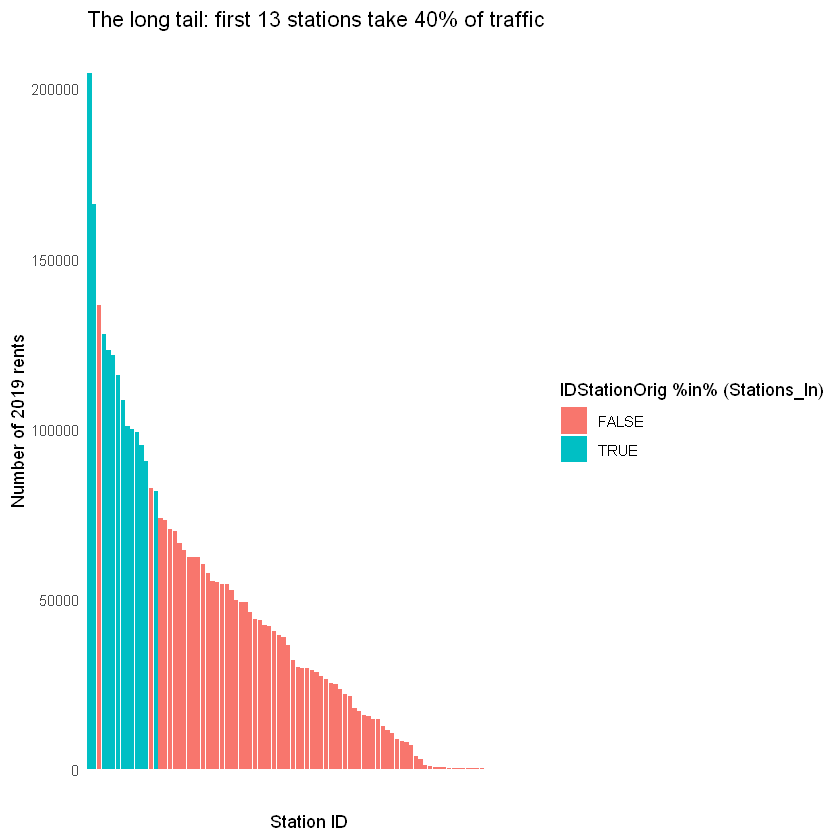

In [20]:
### The long tail plotted

dt %>% filter (substr(TimeStart,1,4)=="2019") %>%
   group_by (IDStationOrig) %>%
   summarise (vol = n()) %>%
   ggplot (aes(x=reorder(IDStationOrig, -vol), vol, fill = IDStationOrig %in% (Stations_In))) + 
   geom_bar(stat = "identity") + scale_color_manual (values=c("#0072B2", "#D55E00")) +
   labs (x = "Station ID", y = "Number of 2019 rents", title = "The long tail: first 13 stations take 40% of traffic") +
   theme_minimal() +
   theme(axis.ticks=element_blank(), axis.text.x=element_blank(), panel.grid.major=element_blank(), panel.grid.minor=element_blank())

### note: station 89 comes #3 in 2019, but put in service in mid 2018 only

In [21]:
### selected 13 takes 40% of traffic

filtered %>% 
   filter (substr(TimeStart,1,4) == "2019") %>%
   group_by (Top_Stations = IDStationOrig %in% Stations_In) %>%
   summarise (vol = n()) %>%
   mutate(Traffic_Percentage = vol / sum(vol))

Top_Stations,vol,Traffic_Percentage
FALSE,2263285,0.5959658
TRUE,1534391,0.4040342


## Slot Positions

Slot positions may hold some valuable information. Next to check is the reliability of this parameter.

In [22]:
### Check Slot / Position unique values

dt [, unique(PosOrig)]
dt [, unique(PosDest)]

[1]  1  6 25 14  8 12 33 19  4 13 16 23 18  2  3 17 21 22  5 39 15 11 28 31 10
[26] 20 27  7  9 26 38 40 24 29 35 34 37 32 36 30

[1] "1"    "NULL" "13"   "6"    "9"    "22"   "28"   "14"   "16"   "5"   
[11] "7"    "20"   "8"    "21"   "18"   "17"   "23"   "4"    "11"   "25"  
[21] "2"    "30"   "15"   "19"   "3"    "26"   "31"   "27"   "10"   "29"  
[31] "39"   "36"   "12"   "40"   "24"   "35"   "33"   "32"   "37"   "34"  
[41] "38"

Similar to Station ID, destination positions contain a "NULL", suggesting error.

In [23]:
### Check if "NULL" position pertains to specific stations. 
#   result shows that it is not pertained to specific station, more generic
cat ("Number of stations with NULL return slot ID: \n")
print (dt [PosDest == "NULL", .N, by = IDStationDest][,.N])

cat ("\nMost notorious stations with NULL position ID:")
head (dt [PosDest == "NULL", .N, by = IDStationDest][order(-N)])


Number of stations with NULL return slot ID: 
[1] 138

Most notorious stations with NULL position ID:

IDStationDest,N
16,13165
54,9154
NULL,6079
11,5766
14,4445
36,4188


Checking position at an arbitrarily picked medium sized station at an arbitrarily selected day below shows that at that station at that randomly picked day all rents were recorded at one position only. At a station with such traffic volume this is obviously an error.

In [24]:
IDStation <- "8"
DATE = "2018-05-10"
dt [substr(TimeStart, 1,10) == DATE & IDStationOrig==IDStation, uniqueN(PosOrig)]

[1] 1

Checking another station on the same date:

In [25]:
IDStation <- "36"
DATE = "2018-05-10"
dt [substr(TimeStart, 1,10) == DATE & IDStationOrig==IDStation, uniqueN(PosOrig)]

[1] 26

Looks better, at least there are more that 1 slots in the log.

On any given data at any number of slot the total number of rents and total number of returns must not differ more than by 1.

This is checked below for slot 1.

In [26]:
### Summing up total number of rent and total number of return events on an arbitrarily selected day must be 1.

dt %>% filter(substr(TimeStart,1,10) == DATE & IDStationOrig==IDStation | 
                 substr(TimeStop,1,10) == DATE & IDStationDest==IDStation) %>%
  summarise (sum(IDStationOrig==IDStation & PosOrig == 1), sum (IDStationDest==IDStation & PosDest == "1"))

sum(IDStationOrig == IDStation & PosOrig == 1),"sum(IDStationDest == IDStation & PosDest == ""1"")"
151,33


What we see is that at this good looking station on the selected date there were 151 more rents from slot 1 than deposits to this same slot. This is wrong.

**Conclusion:** Slot / Position information are absolutely unreliable, best to drop.

## Stock

The goal of the exercise is to do demand forecast based on historical data. However, to be rigorous, we do not have historical demand data. What we have is historical usage data. Ideally the two should be the same, but we can not be sure. To expand a bit the dilemma: later we heavily use the maximum of the number of parallelly rented out bikes at stations at a day. Ideally this would be equal to the demand, but only under one important condition: if it was not supply shortage (capacity limit) at the station when this maximum was reached. If the capacity limit prevented more parallel rentals, then the historical data does not reflect demand but "capacity limited demand".

Though stock was not part of the data, in order to see if we faced demand maximum or "capacity limited demand" maximum it would be helpful if we could figure out the number of bicycles at a station at day start, or at the end of the day.

This is problematic, though. 

We thought that if we match every bike's last return to the station it was returned then we can have a good stock picture. However, our analysis showed that there are quite some bikes transported between stations at nights, which means that finding out the stock at the end of a day does not tell us the number of bikes available at a station the next day. BTW, Bike transfers in a way is not a surprise, after all, this is why we have this exercise: to help improving such logistics by demand forecast.
(We also saw that bikes are not only transported at nights, but sometime during normal days, too.)

Examples to these phenomena are shown below.

The consequence of these dilemma is that when looking at historical data we can not be 100% sure that daily maximum usage reflects daily demand maximum. However, we assumed that usage does reflect forecast, and we base our assumption on the followings:

- We trust in common sense. Maybe occasionally capacity limited usage, but we trust that those who operate this rental service do a good job and make sure that in most of the cases there are enough bikes available.

- Capacity limit is not an easy definition. Is it capacity limit if buyers need to wait in a queue for a bike to be returned for reasonable time? Maybe yes, maybe not.

- Seeing that there are daily transports it is a safe assumption that the service operators quickly and flexibly can adopt to unexpected demand and react to it.

- We had no other choice.

In [27]:
### This example demonstrates that list of bikes finishing day at a station does not reflect next morning stock
# checking station 55 on 2018-05-10 evening and 2018-05-11 morning

# Cretaing temporary data table with converted Date/Time
tmpd <- copy (dt)
tmpd [, TimeStart:= as.POSIXct(TimeStart,format = "%Y-%m-%d %H:%M:%S", tz = "UTC") ]
tmpd [, TimeStop:=  as.POSIXct(TimeStop, format = "%Y-%m-%d %H:%M:%S", tz = "UTC") ]

# filtering data table by time to around picked date based on returned date
tmp_endstate <- tmpd %>% 
  filter( TimeStart + lubridate::ddays(1) > TimeStop) %>% 
  filter( TimeStop > TimeStart) %>%
  filter( TimeStop < lubridate::ymd_hms("2018-05-11 00:00:00") ) %>% 
  filter( TimeStop > lubridate::ymd_hms("2018-05-04 00:00:00") ) 

# filtering data table by time to around picked date based on rent start date
tmp_startstate <- tmpd %>% 
  filter( TimeStart + lubridate::ddays(1) > TimeStop) %>% 
  filter( TimeStop > TimeStart) %>%
  filter( TimeStart > lubridate::ymd_hms("2018-05-11 00:00:00") ) %>% 
  filter( TimeStart < lubridate::ymd_hms("2018-05-18 00:00:00") )

# for every bike in the filtered data find the last deposit (last TimeStop)
tmp_laststation <- tmp_endstate %>% 
  group_by(IDBike) %>% 
  mutate(trip_nth = rank(TimeStop, ties.method = "first", na.last = NA),
         trip_n = n()) %>% 
  filter(trip_nth == max(trip_nth, na.rm = TRUE)) %>% 
  ungroup() %>% 
  filter( trip_nth >=10 )

# for every bike in the filtered data find the first origin (first TimeStart)
tmp_firststation <- tmp_startstate %>% 
  group_by(IDBike) %>% 
  mutate(trip_nth = rank(TimeStart, ties.method = "first", na.last = NA),
         trip_n = n()) %>% 
  filter(trip_nth == min(trip_nth, na.rm = TRUE)) %>% 
  ungroup() %>% 
  filter( trip_n >=10 )

# count the number of bikes last returned on the selected date (2018-05-10) at the selected station (55)
tmp_laststation <- tmp_laststation %>% 
  filter(IDStationDest == "55") %>%
  summarise (n()) %>% pull()

# count the number of bikes first rented on the selected date +1 (2018-05-11) at the selected station (55)
tmp_firststation <- tmp_firststation %>% 
  filter(IDStationOrig == "55") %>%
  summarise (n())  %>% pull()

print (tmp_laststation / tmp_firststation)

rm(list=ls(pattern="tmp"))

# 25% of bikes transported from this station over night. Similar at other stations with varying sign and amount.

[1] 1.25


In [28]:
### This is an exmaple showing that bike transport occurs sometimes (frequently?) during daytime
# below is the history of two arbitrarily picked bikes on the same (arbitrarily) selected day used in prev. example

DATE <- "2018-05-10"

dt [IDBike == "0000164BF5F4" & (substr(TimeStart,1,10) == DATE | substr(TimeStop,1,10)==DATE),][order(TimeStart)]

dt [IDBike == "0000164C43C3" & (substr(TimeStart,1,10) == DATE | substr(TimeStop,1,10)==DATE),][order(TimeStart)]

# the first table shows that the bike was returned to station 57 (row 2), and next picked at station 65 (row 3). Similar in row 6 - 7: 
# bike returned to station 36, then next picked from station 34. The last bike transfer was towards the end of the day, when the bike 
# was moved from station 42 to 10.
# This could be data recording error, but we see similar in the second table row 4 - 5: 
# more or less at the same time as in the first case, (btw. 10 - 12 AM) the bike was transferred from station 36 to 34 
# probably the same transport as row 6-7 in first table.

IDRent,IDUser,IDBike,TimeStart,TimeStop,IDStationOrig,PosOrig,IDStationDest,PosDest,Oper
8681060,34750,0000164BF5F4,2018-05-10 06:09:40.000,2018-05-10 06:22:33.000,23,1,66,1,anderson.rojas
8681201,31676,0000164BF5F4,2018-05-10 06:22:36.000,2018-05-10 06:26:26.000,66,1,57,1,NULL
8682026,111972,0000164BF5F4,2018-05-10 07:28:21.000,2018-05-10 07:34:21.000,65,1,23,1,loaiza.fredy
8682119,109901,0000164BF5F4,2018-05-10 07:35:13.000,2018-05-10 08:05:18.000,23,1,23,1,loaiza.fredy
8682762,32102,0000164BF5F4,2018-05-10 08:22:49.000,2018-05-10 08:30:22.000,23,1,24,1,arango.valeria
8682829,97427,0000164BF5F4,2018-05-10 08:30:33.000,2018-05-10 09:01:28.000,24,1,36,28,NULL
8685740,23560,0000164BF5F4,2018-05-10 12:31:48.000,2018-05-10 12:37:54.000,34,1,63,31,NULL
8686136,98605,0000164BF5F4,2018-05-10 13:04:13.000,2018-05-10 14:01:14.000,63,31,41,13,NULL
8686892,111881,0000164BF5F4,2018-05-10 14:07:50.000,2018-05-10 14:31:10.000,41,13,46,21,NULL
8687491,109436,0000164BF5F4,2018-05-10 14:57:27.000,2018-05-10 15:06:25.000,46,1,12,1,leon.zapata


IDRent,IDUser,IDBike,TimeStart,TimeStop,IDStationOrig,PosOrig,IDStationDest,PosDest,Oper
8682246,91855,0000164C43C3,2018-05-10 07:42:40.000,2018-05-10 07:48:17.000,39,21,9,8,NULL
8682369,104489,0000164C43C3,2018-05-10 07:49:25.000,2018-05-10 08:41:04.000,9,8,36,25,NULL
8683056,16700,0000164C43C3,2018-05-10 08:55:01.000,2018-05-10 09:33:04.000,36,25,41,17,NULL
8683454,16700,0000164C43C3,2018-05-10 09:34:38.000,2018-05-10 10:11:24.000,41,17,36,5,NULL
8685549,7388,0000164C43C3,2018-05-10 12:18:01.000,2018-05-10 12:27:38.000,34,1,20,9,NULL
8686410,101095,0000164C43C3,2018-05-10 13:25:11.000,2018-05-10 13:30:53.000,20,1,10,1,jestrada
8688825,111217,0000164C43C3,2018-05-10 16:27:48.000,2018-05-10 16:33:28.000,10,1,8,1,oscar.ciodaro
8689002,27562,0000164C43C3,2018-05-10 16:37:25.000,2018-05-10 16:47:20.000,8,1,12,1,leon.zapata
8689208,112146,0000164C43C3,2018-05-10 16:49:29.000,2018-05-10 17:36:39.000,12,1,8,1,juan.mejia


## EDA Conclusion

Quality: 

- There were a few negative length rentals, very few in numbers, this should be dropped. Also, all publicly available information tells that above one hour rentals are discouraged, therefore long (longer than 1 day) rentals are treated as errors and dropped. This is also few in numbers.

- Destination station is sometimes wrongly administered, but very rarely. We can live with this.

- Position fields are absolutely unreliable, we can safely drop them.

Selection:

- Data in 2020 is very much distorted due to COVID. As many countries, Colombia also introduced lockdowns and other restrictions, which made 2020 data uncomparable to previous ones. For this reason we decided to leave 2020 out of the investigation. 
We also thought that things changed so much from 2016 that 2016 patterns can not be inferred to these days. We therefore considered 2016 data "staled", and decided to confine our prediction data to 2017, 2018 ad 2019.
To be honest, we (as all others) have no clue how life will look like after the pandemic ends. We assume that bike usage will go up compared to past, and likely we can only to a limited extent infer from pre-covid to past covid times.

- 13 stations make up 40 percent of the traffic. We thought that we focus on the largest most important stations only (see above how we defined most important). This seems to be a rational decision from both business and data quantity perspective. With this we also eliminate the problem of treating sites that have been commissioned or decommissioned during the period.

Other consideration: 

- Though historcial data technically shows usage and not demand, we assume that in this exercise we can treat the two equal with good reasons (discussed).

- The network is very dynamic, with frequent changes, which limits inference potential in the past, and the same also implies that whatever solution is worked out today must be updated frequently. Method is more important than actual result.

# Shaping data, refining scope and objective

Above discussed that in this exercies we will have years 2017 - 2019 in scope as well as looking at only the most important stations, which we defined as those that carried top traffic in 2019 and generally during the entire period.

Hence, the refined objective is: based on 2017 to 2019 historical rental data we create a model to foracast demand. 


## Calculating daily demand

Bearing in mind that the purpose is to optimise load balancing, demand in this context means the maximum number of parallel "net rented" bike at a station during a day. In this context "net rented" means the difference between number of rents and returns since the morning opening times. Its maximum value (well, we will count rent as negative and return as positive, so in technically this maximum is the absolute value of the minimum) tells us how many bikes we need at opening time at the station in order to fulfil all rent demands, without the need for re-load the station during the day. 

Calculating the maximum number of parallel rents at a station in the historical database is done the same way as car counters work in a parking lot: every time a vehicle (in our case it is a bike) enters the station, the counter is incremented by one. Every time a vehicle leaves the station, the counter is decremented by one.

We start the counter at 0 value in the morning, every rent event decrements it, and every return increments this counter. Processing the station's data sequentially over time will enables knowing at any moment the "balance" of the station, i.e. the difference between number of bikes rented out and number of bikes returned. With other words, at any moment we need how many bikes we had to start the day in order not to run out of stock by the time.

This is done by below rent_counter () function. What it does:

- Filters data to the specified station (IDStation) and date (DATE). 

- Duplicates rows where IDStation is both origin and destination of a rent transaction (reason: at start time the counter must be stepped down, at end time the counter must be stepped up. So from a counter step perspective one such row contains two events at different times).

- groups duplicate events (i.e. every duplicated row (pair) will form one group each, and every non duplicated row will form one group (with one element) each. This is needed for using row number to distuinguish a row form its duplicated pair).

- Introduces event time (Time) and Step value (In_Out_Step), which is set in every row according to the below rule:


|  | Station is both Origin & Destination | Station is only Origin | Station is only Destination |
| :- | --- | --- | --- |
| it is 1st row in grp | Step = -1, Time = TimeStart  | Step = -1, Time = TimeStart | Step = +1, Time = TimeStop |
| it is 2nd row in grp | Step = +1, Time = TimeStop  |  |  |

- ungroup and re-arrange by newly assigned event time (Time)

- cumsum the step values


In [29]:
rent_counter <- function (dtpar, IDStation, DATE)
{
  OutStep <- -1
  InStep <- 1
  
    # filter to station and date
  dt_1Station <- dtpar %>%
    filter (substr (TimeStart,1,10) %in% DATE | substr(TimeStop,1,10) %in% DATE) %>%
    filter (IDStationOrig == IDStation | IDStationDest == IDStation) %>%
    data.frame()
  
  # normal branch: date with rent data recorder (dt_1Station is not empty)
  if (dim(dt_1Station)[1] > 0)
  {  
    # duplicate rows where station is both origin and destination
    dt_1Station %>%
      filter (IDStationOrig == IDStationDest) %>%
      bind_rows (.,dt_1Station) %>%
      # group duplicated entries 
      group_by (TimeStart, TimeStop, IDBike) %>%
      # set ActionTime and Step value based on transaction type (rent or return)
      mutate (Time = ifelse (IDStationOrig == IDStation, TimeStart, TimeStop),
              In_Out_Step = ifelse (IDStationOrig == IDStation, -1, 1)) %>%
      mutate (pos = 1:n(), 
              Time = ifelse (pos == 2, TimeStop, Time),
              In_Out_Step = ifelse (pos ==2, 1, In_Out_Step)
      )  %>%
      ungroup() %>%
      arrange (Time) %>%
      # filter those where IDStation was destination but return date was after DATE, or where IDStation was origin but before DATE
      # filter (substr(Time,1,10) == DATE) %>%
      mutate (stock = cumsum(In_Out_Step))
  } else 
  # special branch: date with no rentdata recorded (dt1_Station is empty)
  {
    dt_1Station[1,] <- rep(0, ncol(dt_1Station))
    dt_1Station$stock <- 0
    dt_1Station
  }
  
}

Demonstrating its operation on a station on an aribitrarily picked day.

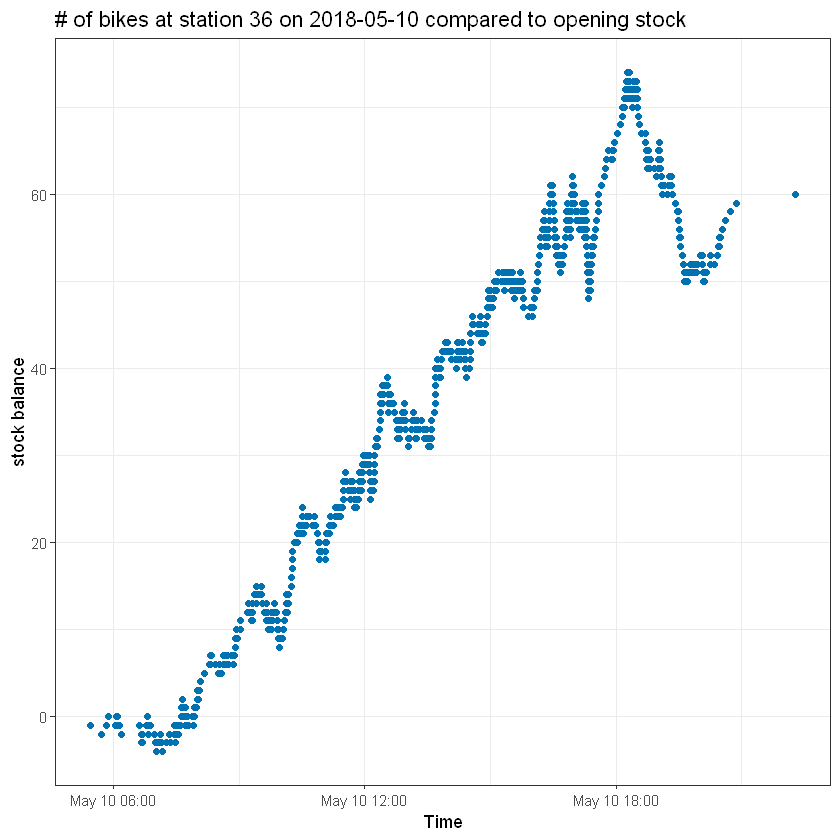

In [30]:
IDStation <- "36"
DATE <- "2018-05-10"

rent_counter(dt, IDStation, "2018-05-10") %>%
  ggplot (aes(as.POSIXct(Time, format = "%Y-%m-%d %H:%M:%S", tz="UTC"), stock)) + geom_point(color = "#0072B2") + 
  labs (x = "Time", y = "stock balance", title = "# of bikes at station 36 on 2018-05-10 compared to opening stock" ) + 
  theme_bw()

Interpretation of the figure: the minimum value was reached at in the morning between 6 AM and 9 AM at the value of -5, which means if we had 5 bikes at the station at opening time, then at this time the station were out of stock, but serving all demands. After that time more bikes were returned at this station than rented. At the end of the day there were 60 more bikes at the station than at opening times (assuming that in the meantime there was no bike transport form this station, which BTW. we saw above was not the case). Or with other words, during the day there were 60 more returns to this station than rents form this station.


Sanity check: the number of times station featured as Destination on the given day must be 60 times more than the number of times this station featured as Origin.

In [31]:
### sanity check of above fun call: difference btw # of rents and # of returns must match to rightmost value on above plot

# number of returns
dt %>% filter (substr(TimeStop,1,10)==DATE) %>%
   filter (IDStationDest == IDStation) %>%
   summarise (n())

# number of rents
dt %>% filter (substr(TimeStart,1,10)==DATE) %>%
   filter (IDStationOrig == IDStation) %>%
   summarise (n())


n()
400


n()
340


Looking at another station the same day below.

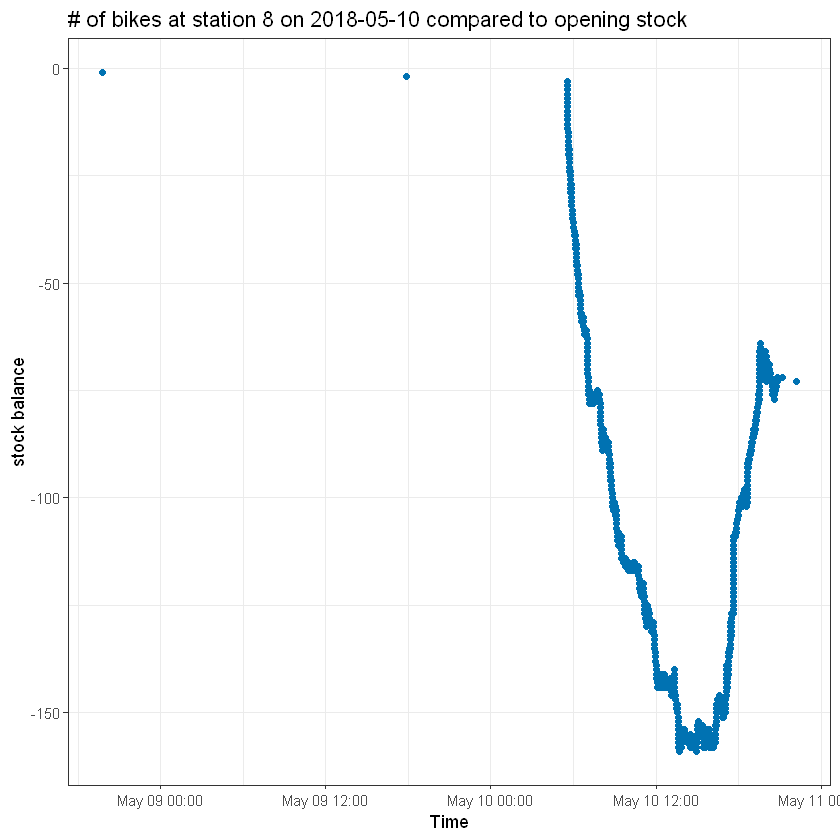

In [32]:
IDStation <- "8"
DATE <- "2018-05-10"

rent_counter(dt, IDStation, "2018-05-10") %>%
  ggplot (aes(as.POSIXct(Time, format = "%Y-%m-%d %H:%M:%S", tz="UTC"), stock)) + geom_point(color = "#0072B2") +
  labs (x = "Time", y = "stock balance", title = "# of bikes at station 8 on 2018-05-10 compared to opening stock" ) + 
  theme_bw()

This station behaves differently. From opening until about 1PM there were more rents than returns. The minimum was reached after noon at about -155, meaning that at that point of time there were 155 bikes less at the station than at opening (provided that there was no bike transfer to/from this station). In the afternoon there were more returns to this station than rents, and by closing time the station stock balance was -71, meaning that along the day there were 71 more rents than returns here.

Note: the tow left points at on the left are "negative duration" faulty data, these will be taken care of in the next sections, so will not be there during modelling.

In [33]:
### sanity check of above fun call: difference btw # of rents and # of returns must match to rightmost value on above plot

# number of returns
dt %>% filter (substr(TimeStop,1,10)==DATE) %>%
   filter (IDStationDest == IDStation) %>%
   summarise (n())

# number of rents
dt %>% filter (substr(TimeStart,1,10)==DATE) %>%
   filter (IDStationOrig == IDStation) %>%
   summarise (n())


n()
545


n()
616


## Filtering and Cleaning Data

Therefore we filter our data to these years and these stations only, then check if previously seen false observations (e.g. negative duration) as well as columns we earlier deemed useless or found no value for us.

First, data is filtered to include selected station and years, and those columns that in first EDA proved to be erroneous and/or useless in this analysis are removed.

In [34]:
# define selection
Stations_In <- c("8", "7", "12", "3", "2", "1", "70", "67", "10", "66", "41", "56", "23")
Years_In <- c("2017", "2018", "2019")

# limit data
dt_In <- dt %>%
  filter (IDStationOrig %in% Stations_In | IDStationDest %in% Stations_In)  %>%
  filter (substr (TimeStart, 1,4) %in% Years_In | substr (TimeStop, 1, 4) %in% Years_In) %>%
  data.table()


Negative duration as well as long duration (>1 day, which BTW does not mean same day) rents dropped (not many, ~0.01% of total).

sameday,n()
FALSE,1824
TRUE,5698839


min(TimeStart),max(TimeStop)
2017-01-02 04:43:33.000,2019-12-31 16:27:12.000


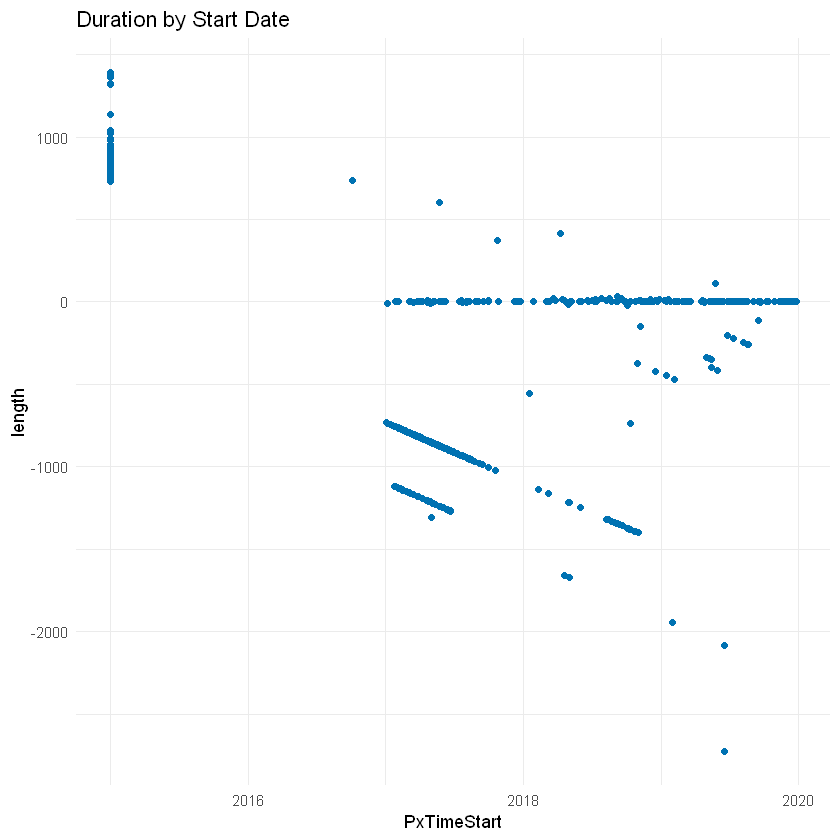

In [35]:
# sameday rents: rental and return same day
dt_In %>% group_by (sameday = substr(TimeStart, 1,10) == substr(TimeStop,1,10)) %>%
  summarise(n())

# nature of strange lengths
dt_In %>%
  mutate (PxTimeStart = as.POSIXct(TimeStart, format = "%Y-%m-%d %H:%M:%S", tz="UTC")) %>%
  mutate (PxTimeStop = as.POSIXct(TimeStop, format = "%Y-%m-%d %H:%M:%S", tz="UTC")) %>%
  mutate (length = difftime(PxTimeStop, PxTimeStart, units = "days")) %>%
  mutate (length = as.numeric(length)) %>%
  filter (abs(length) > 1) %>%
  ggplot (aes(PxTimeStart, length)) + geom_point(color = "#0072B2") + theme_minimal() + labs (title = "Duration by Start Date")

# Removing negative and long duration rental data
dt_In <- dt_In %>%
  mutate (PxTimeStart = as.POSIXct(TimeStart, format = "%Y-%m-%d %H:%M:%S", tz="UTC")) %>%
  mutate (PxTimeStop = as.POSIXct(TimeStop, format = "%Y-%m-%d %H:%M:%S", tz="UTC")) %>%
  mutate (length = difftime(PxTimeStop, PxTimeStart, units = "days")) %>%
  mutate (length = as.numeric(length)) %>%
  filter (PxTimeStop > PxTimeStart) %>%
  filter (length < 1) %>%
  data.table()

# checking minimum and maximum dates in data (make sure we have no over arching rents, e.g.. started before ended during period)
dt_In %>% summarise (min(TimeStart), max(TimeStop))

We do not care about "negative spikes", as discussed we can live with them.

In [36]:
# Not using User, Loan, and Oper for the exercise, saw on "8" that Positions are useless
dt_In <- dt_In %>% select (IDBike, TimeStart, TimeStop, IDStationOrig, IDStationDest) %>% data.table()

## Creating Time Series data

After all the above analisys and considerations the following will form the final time series dataset:

- Include Selected 13 stations (giving 40% of total rent transactions).

- Include years 2017 - 2019 (Data before 2017 is excluded for two reasons: 1. many missing observations particularly in 2016, 2. we can not assume long stationarity, e.g. patterns in 2016 are hardly applicable in 2021. Data in 2020 and beyond excluded due to COVID and related lockdowns, restrictions.). 

- Data recorded every day are: 1. minimum of stock. As explained above in "Calculating daily demand" chapter, this basically tells us how many bikes we need to install at the start of the day in order to fulfill all demands (with the note that from data we do not know if in the past the daily stock minimum was hit naturally, or by running out of bikes). 2. daily closing stock (this basically tells us how many more bikes we ended the day than started with). The latter will not be used in forecast, but might be useful in future works.

We will predict the demand, which means that based on historical data we will predict the daily minimum stock based on the past.

What done below is to pick a station among those that are in scope, go through each day during the 2017 - 2019 period, and on each date record the stock minimum and stock closing values. Then repeat the same for the other 12 stations that we defined as most important stations (carrying 40% of total traffic). **As the process takes about 45 minutes per station, due to time constraints in this exercise we limited ourselves to one station only. All other 12 important stations can be modelled and predicted exactly the same way.**

As already discussed, due to the dynamics anyhow the method is the real value not the actual result. The method introduced below on the biggest station ("8") can be easily done on all other stations.

We will work on the cleaned data.

In [37]:
IDStation <- "8"
st8 <- do.call ( rbind, lapply (as.character(seq (as.Date ("2017-01-01"), as.Date("2019-12-31"), by = 1)), 
                                function(x) rent_counter (dt_In, IDStation, x) %>% 
                                  summarise (daily_min = min(stock), daily_close = last(stock))))
st8$date <- as.character(seq (as.Date ("2017-01-01"), as.Date("2019-12-31"), by = 1))
st8$station <- IDStation

The below code chunk is commented out in oorder not to waste time (running it takes ~12 hours).

In [38]:
### Code to enable when run to all stations

#IDStation <- "7"
#st7 <- do.call ( rbind, lapply (as.character(seq (as.Date ("2017-01-01"), as.Date("2019-12-31"), by = 1)), 
#                                function(x) rent_counter (dt_In, IDStation, x) %>% 
#                                  summarise (daily_min = min(stock), daily_close = last(stock))))
#st7$date <- as.character(seq (as.Date ("2017-01-01"), as.Date("2019-12-31"), by = 1))
#st7$station <- IDStation

#IDStation <- "12"
#st7 <- do.call ( rbind, lapply (as.character(seq (as.Date ("2017-01-01"), as.Date("2019-12-31"), by = 1)), 
#                                function(x) rent_counter (dt_In, IDStation, x) %>% 
#                                  summarise (daily_min = min(stock), daily_close = last(stock))))
#st12$date <- as.character(seq (as.Date ("2017-01-01"), as.Date("2019-12-31"), by = 1))
#st12$station <- IDStation

#IDStation <- "3"
#st3 <- do.call ( rbind, lapply (as.character(seq (as.Date ("2017-01-01"), as.Date("2019-12-31"), by = 1)), 
#                                function(x) rent_counter (dt_In, IDStation, x) %>%  
#                                  summarise (daily_min = min(stock), daily_close = last(stock))))
#st3$date <- as.character(seq (as.Date ("2017-01-01"), as.Date("2019-12-31"), by = 1))
#st3$station <- IDStation

#IDStation <- "2"
#st2 <- do.call ( rbind, lapply (as.character(seq (as.Date ("2017-01-01"), as.Date("2019-12-31"), by = 1)), 
#                                function(x) rent_counter (dt_In, IDStation, x) %>%  
#                                  summarise (daily_min = min(stock), daily_close = last(stock))))
#st2$date <- as.character(seq (as.Date ("2017-01-01"), as.Date("2019-12-31"), by = 1))
#st2$station <- IDStation

#IDStation <- "1"
#st1 <- do.call ( rbind, lapply (as.character(seq (as.Date ("2017-01-01"), as.Date("2019-12-31"), by = 1)), 
#                                function(x) rent_counter (dt_In, IDStation, x) %>%  
#                                  summarise (daily_min = min(stock), daily_close = last(stock))))
#st1$date <- as.character(seq (as.Date ("2017-01-01"), as.Date("2019-12-31"), by = 1))
#st1$station <- IDStation

#IDStation <- "70"
#st70 <- do.call ( rbind, lapply (as.character(seq (as.Date ("2017-01-01"), as.Date("2019-12-31"), by = 1)), 
#                                function(x) rent_counter (dt_In, IDStation, x) %>%  
#                                  summarise (daily_min = min(stock), daily_close = last(stock))))
#st70$date <- as.character(seq (as.Date ("2017-01-01"), as.Date("2019-12-31"), by = 1))
#st70$station <- IDStation

#IDStation <- "67"
#st67 <- do.call ( rbind, lapply (as.character(seq (as.Date ("2017-01-01"), as.Date("2019-12-31"), by = 1)), 
#                                function(x) rent_counter (dt_In, IDStation, x) %>%  
#                                  summarise (daily_min = min(stock), daily_close = last(stock))))
#st67$date <- as.character(seq (as.Date ("2017-01-01"), as.Date("2019-12-31"), by = 1))
#st67$station <- IDStation

#IDStation <- "10"
#st10 <- do.call ( rbind, lapply (as.character(seq (as.Date ("2017-01-01"), as.Date("2019-12-31"), by = 1)), 
#                                function(x) rent_counter (dt_In, IDStation, x) %>%  
#                                  summarise (daily_min = min(stock), daily_close = last(stock))))
#st10$date <- as.character(seq (as.Date ("2017-01-01"), as.Date("2019-12-31"), by = 1))
#st10$station <- IDStation

#IDStation <- "66"
#st66 <- do.call ( rbind, lapply (as.character(seq (as.Date ("2017-01-01"), as.Date("2019-12-31"), by = 1)), 
#                                function(x) rent_counter (dt_In, IDStation, x) %>%  
#                                  summarise (daily_min = min(stock), daily_close = last(stock))))
#st66$date <- as.character(seq (as.Date ("2017-01-01"), as.Date("2019-12-31"), by = 1))
#st66$station <- IDStation

#IDStation <- "41"
#st41 <- do.call ( rbind, lapply (as.character(seq (as.Date ("2017-01-01"), as.Date("2019-12-31"), by = 1)), 
#                                function(x) rent_counter (dt_In, IDStation, x) %>%  
#                                  summarise (daily_min = min(stock), daily_close = last(stock))))
#st41$date <- as.character(seq (as.Date ("2017-01-01"), as.Date("2019-12-31"), by = 1))
#st41$station <- IDStation

#IDStation <- "56"
#st56 <- do.call ( rbind, lapply (as.character(seq (as.Date ("2017-01-01"), as.Date("2019-12-31"), by = 1)), 
#                                function(x) rent_counter (dt_In, IDStation, x) %>%  
#                                  summarise (daily_min = min(stock), daily_close = last(stock))))
#st56$date <- as.character(seq (as.Date ("2017-01-01"), as.Date("2019-12-31"), by = 1))
#st56$station <- IDStation

#IDStation <- "23"
#st23 <- do.call ( rbind, lapply (as.character(seq (as.Date ("2017-01-01"), as.Date("2019-12-31"), by = 1)), 
#                                function(x) rent_counter (dt_In, IDStation, x) %>%  
#                                  summarise (daily_min = min(stock), daily_close = last(stock))))
#st23$date <- as.character(seq (as.Date ("2017-01-01"), as.Date("2019-12-31"), by = 1))
#st23$station <- IDStation

In [39]:
### Code to enable when run to all stations
# sts <- rbind (st8, st7, st12, st3, st2, st1, st70, st67, st10, st66, st41, st56, st23 )

In [40]:
### done just to use the same variable as for complete network data
sts <- st8

## Building prediction model

As explained above, we created the time series data for the biggest station only. As a consequence, the model will also be implemented for this most important station only now due to time constraints.

In real world whatever is demonstrated below (as a beta pilot) should be implemented to all important stations.

### Adding Public Holiday and Day of Week data

In [41]:
read_colombia_holidays <- function (year)
{
  common <- "https://www.officeholidays.com/countries/colombia/"
  link <- paste0 (common, year)
  pubs <- XML::readHTMLTable(readLines(link), 
                             colClasses = c("character", "character"),
                             stringsAsFactors = FALSE)[[1]]
  pubs$Year <- year
  pubs$date <- as.Date(paste(pubs$Year, pubs$Date, sep = ""), format = "%Y%b %d")
  return (pubs)
}

pubs <- do.call (rbind, lapply (Years_In, function(x) read_colombia_holidays(x))) %>%
  select (date) %>% mutate (Holi = 1) %>% mutate (date = as.character(date))


In [42]:
# add public holidays to table as well as DayOfWeek and month
sts <- sts %>% 
   left_join (pubs) %>% 
   mutate (Holi = tidyr::replace_na(Holi, 0)) %>%
   mutate (DOW = as.POSIXlt(as.Date(date))$wday) %>%
   mutate (month = as.POSIXlt(as.Date(date))$mon)

Joining, by = "date"


### Adding weather data

Weather can impact willingnes to bike.

Medullin weather info is obtained using the GSODR package. 

Once data is downloaded, it is filtered to selected period (2017 - 2019), then to one station that is closest to Medellin center, and finally parameters that are likely more impactful (and contain other than NA value for the period) are extracted and added to the historical demand data table.

The parameters kept from the weather data are mean, min, max temperature (TEMP, MIN, MAX), Precipitation (PERC), Windspeed (WDSP, MXSPD), Snow (SNDP), and fog info (I_FOG). For further details please look at the dictionary available at https://www7.ncdc.noaa.gov/CDO/GSOD_DESC.txt.

In [43]:
### collecting weather info for the period
library(GSODR)

medellin <- nearest_stations(LAT = 6.2765,
                             LON = -75.5648,
                             distance = 50)

med_st <- get_GSOD(years = as.numeric(Years_In), station = medellin)

med_st <- med_st %>% 
   filter (LATITUDE == 6.220) %>%
   select (YEARMODA, TEMP, MIN, MAX, PRCP, WDSP, MXSPD, SNDP, I_FOG) %>% 
   mutate (date = as.character(YEARMODA)) %>%
   data.table()

Warning message:
"package 'GSODR' was built under R version 3.6.3"

Checking weather data completeness and treating incomplete data

In [44]:
### NA stat
med_st[, lapply(.SD, function(x) sum(is.na(x)))]

YEARMODA,TEMP,MIN,MAX,PRCP,WDSP,MXSPD,SNDP,I_FOG,date
0,0,0,0,65,2,2,1086,727,0


[1]  0.0   NA  2.0 35.1 21.1  0.3  1.0 23.9 14.0  6.1 19.0  3.0 10.9  0.5 32.0
[16] 27.9 13.0 11.9  0.8  4.1 41.9  7.1 38.1 18.0  5.1  7.9 15.0 17.0 16.0  9.9
[31] 20.1 24.9 31.0 57.9 34.0  8.9 25.9 51.1 23.1 33.0 30.0 36.1 48.0 67.1 39.9
[46] 40.9

[1] NA  1

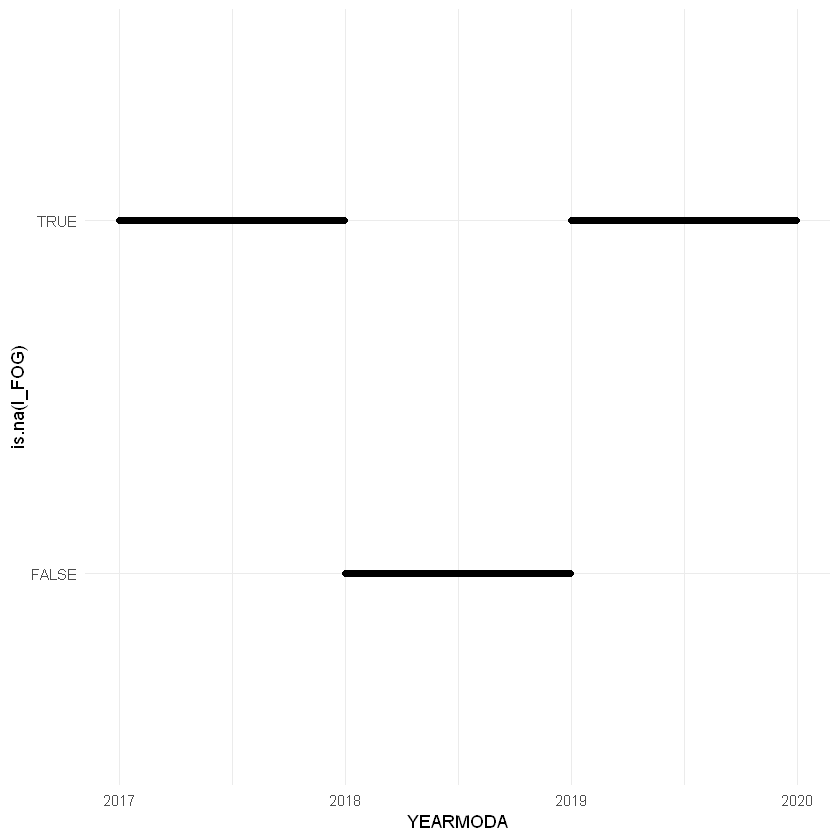

DoW,n()
0,6
1,11
2,14
3,11
4,10
5,5
6,8


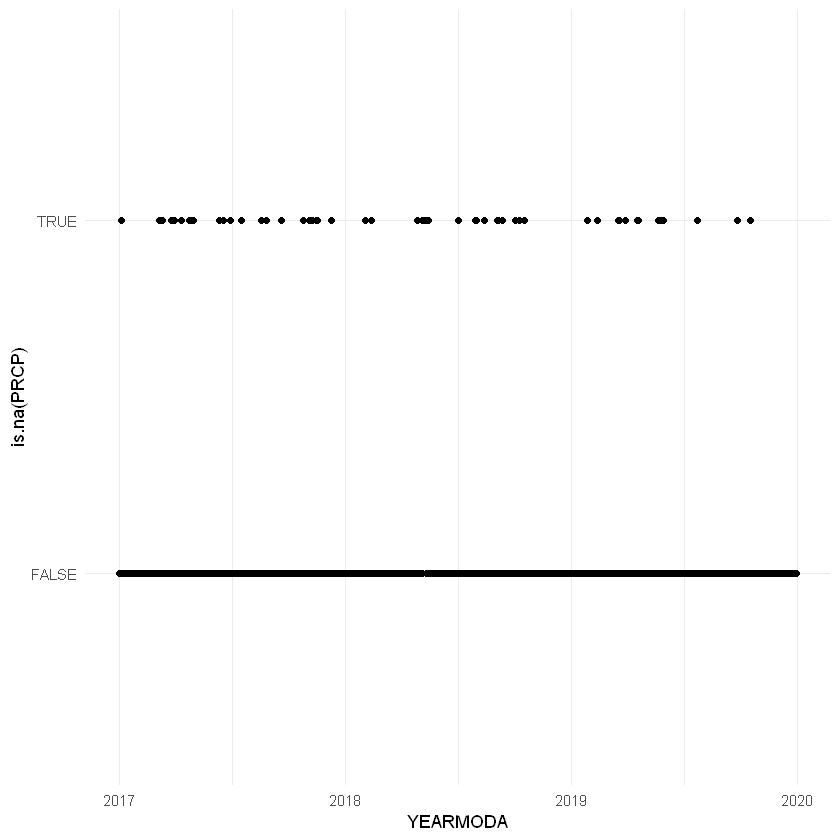

In [45]:
### NA details
med_st [, unique(PRCP)]
med_st [, unique(I_FOG)]

med_st %>%
   ggplot (aes(YEARMODA, is.na(I_FOG))) + geom_point() + theme_minimal()

med_st %>%
   ggplot (aes(YEARMODA, is.na(PRCP))) + geom_point() + theme_minimal()

med_st %>% filter (is.na(PRCP)) %>%
   mutate (DoW = as.POSIXlt(YEARMODA)$wday) %>%
   group_by (DoW) %>%
   summarise (n())


I_FOG should be dropped: nN 2017 and 2019 this is set to 1, in 2018 to NA. It is useless.

PRCP is different. First, NAs here seem to be missing random. NA may or may not be the same as 0. Here NA is to be converted to 0 and an extra variable marks that this has been a manual correction.

SNDP is the snow indicator, based on Medellin climate we can assume that there was really only one snowy day and NAs can be converted to 0.

WDSP amd MXSPD may or may not mean 0 windspeed on these 2 days, but as the number of NAs is only 0.2%, these are simply converted to 0.


In [46]:
med_st <- med_st %>%
   select (-I_FOG) %>%
   mutate (WDSP = tidyr::replace_na(WDSP, 0)) %>%
   mutate (MXSPD = tidyr::replace_na(MXSPD, 0)) %>%
   mutate (SNDP = tidyr::replace_na(SNDP, 0)) %>%
   mutate (PRCP_Miss = ifelse (is.na(PRCP),1,0), PRCP = tidyr::replace_na(PRCP, 0)) %>%
   data.table()

### Adding weather data to daily demand data

In [47]:
sts <- sts %>% left_join (med_st) %>% data.table()

Joining, by = "date"


### Complete missing weather info form other station nearby

In [48]:
### prind dates with weather info not available
Missing_Dates <- sts [is.na(YEARMODA), date]
Missing_Dates

[1] "2017-01-29" "2017-04-26" "2017-04-27" "2018-04-29" "2018-04-30"
[6] "2018-05-01" "2018-07-21" "2018-07-22"

The other weather station GSODR terurned was within 50 km radius, we could assume that on these particular days the weather there was more or less the same as in Medellin. 

In [49]:
### Download weather info from the other nearby station
get_GSOD(years = as.numeric(Years_In), station = medellin) %>%
   filter (LATITUDE == 6.220) %>%
   select (YEARMODA, TEMP, MIN, MAX, PRCP, WDSP, MXSPD, SNDP, I_FOG) %>% 
   mutate (date = as.character(YEARMODA)) %>%
   select (-I_FOG) %>%
   filter (date %in% Missing_Dates)
   

YEARMODA,TEMP,MIN,MAX,PRCP,WDSP,MXSPD,SNDP,date


No info is available from the next station either, so treat these NAs and mark in a new variable weather info unavailability

In [50]:
### Treat dates whene there is missing weather info

# Look at overall NA stat, only 8 columns may contain such
sts[, lapply(.SD, function(x) sum(is.na(x)))]
             

daily_min,daily_close,date,station,Holi,DOW,month,YEARMODA,TEMP,MIN,MAX,PRCP,WDSP,MXSPD,SNDP,PRCP_Miss
0,0,0,0,0,0,0,8,8,8,8,8,8,8,8,8


In [51]:
### Introduce Missing weather indicator and convert all NAs to 0

sts <- sts %>% mutate (Weather_Miss = ifelse (is.na(PRCP),1,0)) %>% 
             select (-YEARMODA) %>%
             replace(is.na(.), 0) %>% data.table()

In [52]:
### Rename weather variables for easier handling later
old_names <- c("TEMP", "MIN", "MAX", "PRCP", "WDSP", "MXSPD", "SNDP", "PRCP_Miss", "Weather_Miss")
new_names <- c("w_TEMP", "w_MIN", "w_MAX", "w_PRCP", "w_WDSP", "w_MXSPD", "w_SNDP", "w_PRCP_Miss", "w_Weather_Miss")
sts <- sts %>% rename_at(vars(old_names), ~ new_names)

Now we have 3 years daily demand and weather data for station "8" (the interval on the lower end is limited by many missing data and limited inference potential, on the higher end limited by COVID restrictions driven pattern changes).

The task is the following: based on 3 years historical data we need to make demand prediction. What we try to predict is tomorrow's demand based on past traffic and weather data.

We tried Recurrent Neural Network and XGBoost as predictive models. The latter performed better, therefore here only this model is shown.

### Create dataset for XGBoost

XGBoost is not time sensitive, therefore we need to bring historical data to the row of the actual observation. After some experimentations we found that data older than 3 days have very little impact on next day's prediction, therefore we used 3 days data to predict. 

In prediction we tried to predict one day ahead (i.e. after closing D date predicting D + 1 date based on data from dates D, D - 1, D - 2) as well as two days ahead.

In [53]:
### data for D + 1 xgboost model

data <- sts %>% 
  mutate_at(vars(starts_with("w_")), .funs = list(l1 = ~lag (., 1))) %>%
  rename_at( vars( contains( "_l1") ), list( ~paste("l1", gsub("_l1", "", .), sep = "_") ) ) %>%
  mutate_at(vars(starts_with("w_")), .funs = list(l2 = ~lag (., 2))) %>%
  rename_at( vars( contains( "_l2") ), list( ~paste("l2", gsub("_l2", "", .), sep = "_") ) ) %>%
  mutate_at(vars(starts_with("w_")), .funs = list(l3 = ~lag (., 3))) %>%
  rename_at( vars( contains( "_l3") ), list( ~paste("l3", gsub("_l3", "", .), sep = "_") ) ) %>%
  #mutate_at(vars(starts_with("w_")), .funs = list(l4 = ~lag (., 4))) %>%
  #rename_at( vars( contains( "_l4") ), list( ~paste("l4", gsub("_l4", "", .), sep = "_") ) ) %>%
  #mutate_at(vars(starts_with("w_")), .funs = list(l5 = ~lag (., 5))) %>%
  #rename_at( vars( contains( "_l5") ), list( ~paste("l5", gsub("_l5", "", .), sep = "_") ) ) %>%
  mutate (l1_daily_min = lag (daily_min, 1)) %>%
  mutate (l2_daily_min = lag (daily_min, 2)) %>%
  mutate (l3_daily_min = lag (daily_min, 3)) %>%
  #mutate (l4_daily_min = lag (daily_min, 4)) %>%
  #mutate (l5_daily_min = lag (daily_min, 5)) %>%
  mutate (l1_Holi = lag (Holi, 1)) %>%
  #mutate (l2_Holi = lag (Holi, 2)) %>%
  #mutate (l3_Holi = lag (Holi, 3)) %>%
  # remove those where we do not have previous 3 days
  dplyr::slice (4:nrow(sts)) %>%
  data.table()

We also assumed that precise weather forecast is available for the next day, therefore we included weather related data for the date to be predicted. With this assumption created training and test datasets. 

It is important (especially in such a dynamic environment) to use latest data for the test set, i.e. we used the last ~250 observations to test the model, and the first 830 observations to train and validate the model (using 5 fold CV).

In [54]:
data_train <- data %>% 
  select (-daily_min, - daily_close, -date, -station,  -w_PRCP, 
                               - w_WDSP, -w_MXSPD, -w_SNDP, -w_PRCP_Miss, -w_Weather_Miss) %>%
  dplyr::slice (1: 830) %>%
  data.table()

data_test <- data %>% 
  select (-daily_min, - daily_close, -date, -station,  -w_PRCP, 
                               - w_WDSP, -w_MXSPD, -w_SNDP, -w_PRCP_Miss, -w_Weather_Miss) %>%
  dplyr::slice (831: nrow(data)) %>%
  data.table()

label_train <- data %>%
  dplyr::slice (1: 830) %>%
  select (daily_min) %>%
  data.table()

label_test <- data %>%
  dplyr::slice (831:nrow(data)) %>%
  select (daily_min) %>%
  data.table()

Data for one day: 

- actual day: DOW, Holiday indicator, weather forecast (w_TEMP, w_MIN, w_MAX) 

- historic (D-1, D-2, D-3): weather data, daily stock data

- historic (D-1): Holiday indicator for D - 1

Note: as this is a decision tree based algorithm, there is no need to convert categorical data from numeric to dummy, tree will cope with it.

In [55]:
### Data for one day
colnames (data_train)

[1] "Holi"              "DOW"               "month"            
 [4] "w_TEMP"            "w_MIN"             "w_MAX"            
 [7] "l1_w_TEMP"         "l1_w_MIN"          "l1_w_MAX"         
[10] "l1_w_PRCP"         "l1_w_WDSP"         "l1_w_MXSPD"       
[13] "l1_w_SNDP"         "l1_w_PRCP_Miss"    "l1_w_Weather_Miss"
[16] "l2_w_TEMP"         "l2_w_MIN"          "l2_w_MAX"         
[19] "l2_w_PRCP"         "l2_w_WDSP"         "l2_w_MXSPD"       
[22] "l2_w_SNDP"         "l2_w_PRCP_Miss"    "l2_w_Weather_Miss"
[25] "l3_w_TEMP"         "l3_w_MIN"          "l3_w_MAX"         
[28] "l3_w_PRCP"         "l3_w_WDSP"         "l3_w_MXSPD"       
[31] "l3_w_SNDP"         "l3_w_PRCP_Miss"    "l3_w_Weather_Miss"
[34] "l1_daily_min"      "l2_daily_min"      "l3_daily_min"     
[37] "l1_Holi"

### Running the model

1. Finding optimal value of some XGBoost parameters with gridsearch

In [56]:
library (xgboost)

Warning message:
"package 'xgboost' was built under R version 3.6.3"
Attaching package: 'xgboost'

The following object is masked from 'package:dplyr':

    slice



In [57]:
### Converting data frames to xgb matrix for xgboost
dtrain <- xgb.DMatrix(data = as.matrix(data_train), label = label_train$daily_min)
dtest <- xgb.DMatrix(data = as.matrix(data_test))

In [58]:
### Gridsearch setting: create GridSearch table
searchGridSubCol <- expand.grid(subsample = c(0.5, 0.6, 0.7, 0.8, 1), 
                                colsample_bytree = c(0.5, 0.6, 0.7, 0.8, 1),
                                lambda = c(0.01, 0.1, 1),
                                min_child = seq(1), 
                                eta = c(0.28, 0.3, 0.32)
)


SearchGrid_XGB <- function (searchGridSubCol, x_train, y_train)
{
  ### Number of Itreations per search
  niters <- 25
  
  
  ### Do the Search
  xgbstuff <- apply(searchGridSubCol, 1, function(parameterList)
  {
    
    #Extract Parameters to test
    currentSubsampleRate <- parameterList[["subsample"]]
    currentColsampleRate <- parameterList[["colsample_bytree"]]
    currentLambda <- parameterList[["lambda"]]
    currentEta <- parameterList[["eta"]]
    currentMinChild <- parameterList[["min_child"]]
    xgboostModelCV <- xgb.cv(data = x_train, 
                             #label = y_train, 
                             nfold = 5,
                             objective = "reg:squarederror", nrounds = niters, scale_pos_weight = 0.12,
                             verbose = FALSE, 
                             "eval_metric" = "rmse",
                             "lambda" = currentLambda, "eta" = currentEta,                               
                             "subsample" = currentSubsampleRate, "colsample_bytree" = currentColsampleRate,
                             print_every_n = 10, 
                             "min_child_weight" = currentMinChild, booster = "gbtree",
                             early_stopping_rounds = 10)
    return(c(currentSubsampleRate, currentColsampleRate, currentLambda, 
             currentEta, currentMinChild, xgboostModelCV$evaluation_log))
  })
  
  ### Evaluate the search: collect and print the best AUC parameter combination
  mean_test_rmse <- unlist(lapply (xgbstuff, function (x) mean(x$test_rmse_mean)))
  min_test_rmse_index <- which.min (mean_test_rmse)
  return(xgbstuff [min_test_rmse_index])
  
}

SearchGrid_XGB (searchGridSubCol,dtrain, getinfo(dtrain, 'label'))

[[1]]
[[1]][[1]]
[1] 1

[[1]][[2]]
[1] 1

[[1]][[3]]
[1] 1

[[1]][[4]]
[1] 0.28

[[1]][[5]]
[1] 1

[[1]]$iter
 [1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25

[[1]]$train_rmse_mean
 [1] 78.200702 59.319878 45.961740 36.766570 30.340630 25.937657 22.502780
 [8] 19.654319 17.664898 16.001423 14.670647 13.567437 12.870385 11.970231
[15] 11.360350 10.576134  9.955847  9.482615  9.079857  8.739005  8.323019
[22]  8.087060  7.718786  7.428012  7.133428

[[1]]$train_rmse_std
 [1] 0.7008663 0.5998426 0.5471853 0.3828787 0.4898278 0.3800188 0.7114449
 [8] 0.7245690 0.6250534 0.4902492 0.6152232 0.6332323 0.8561805 0.9431587
[15] 0.7286826 0.6248042 0.5162867 0.4720953 0.4697854 0.4862371 0.4922309
[22] 0.4777500 0.4131957 0.4317603 0.4093264

[[1]]$test_rmse_mean
 [1] 78.47295 60.20280 47.60286 39.61939 34.44624 31.43616 29.75615 29.07801
 [9] 28.44584 28.27725 28.03860 28.02130 28.03186 27.96436 27.91299 27.90216
[17] 28.02422 28.00366 28.02773 27.98787 27.99218 27.99154 27.93064 27.98402
[25] 28.00779

[[1]]$test_rmse_std
 [1] 2.903343 2.720610 2.535386 2.480988 2.613645 2.892230 3.104996 3.116590
 [9] 3.212108 3.197671 3.148010 3.038814 3.221568 3.238230 3.264939 3.196750
[17] 3.157335 3.118116 3.077900 2.987559 3.054005 3.027581 3.063511 3.044395
[25] 3.036872

2. Setting xgboost pareameters based on gridsearch result and several manual trials

In [59]:
params <- list(booster = "gbtree", objective = "reg:squarederror", max_depth=4, colsample_bytree = 1, subsample = 1, 
               scale_pos_weight = 0.12, lambda = 1, eta = 0.32, eval_metric = "rmse")

3. Running XGBoost on 5 fold cross validation to see the model accuracy

In [60]:
### cross validation
xgbcv <- xgb.cv( params = params, data = dtrain, nrounds = 20, nfold = 5, showsd = T, stratified = T, print_every_n = 10, early_stop_round = 20, maximize = F)


[1]	train-rmse:75.202478+0.237233	test-rmse:75.371939+1.878491 
[11]	train-rmse:20.466795+0.406918	test-rmse:28.143974+1.734143 
[20]	train-rmse:15.706478+0.368366	test-rmse:28.419002+2.163838 


4. Running the model

The nrdounds came empirically after several runs.

In [61]:
# model
set.seed(123)
bst <- xgboost(data = dtrain, nrounds = 20, params = params)

[1]	train-rmse:75.191467 
[2]	train-rmse:56.008636 
[3]	train-rmse:43.288994 
[4]	train-rmse:35.004906 
[5]	train-rmse:30.196194 
[6]	train-rmse:26.937475 
[7]	train-rmse:25.217125 
[8]	train-rmse:23.739828 
[9]	train-rmse:22.597858 
[10]	train-rmse:21.956375 
[11]	train-rmse:21.161386 
[12]	train-rmse:20.670809 
[13]	train-rmse:20.376825 
[14]	train-rmse:19.869902 
[15]	train-rmse:19.247334 
[16]	train-rmse:18.760307 
[17]	train-rmse:18.552013 
[18]	train-rmse:18.191917 
[19]	train-rmse:17.637455 
[20]	train-rmse:17.244740 


5. Evaluating the model

In [62]:
y_test_prob_vec <- predict (bst, dtest)
mean(y_test_prob_vec - label_test$daily_min)
summary(abs(y_test_prob_vec - label_test$daily_min))

sum(abs(y_test_prob_vec - label_test$daily_min) > 50)

[1] 3.157932

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
  0.07219   6.05612  14.44339  19.96078  29.31973 105.38129 

[1] 19

The median is 15, i.e. in half of the days the predicted number of bicikles differ from the actual needed ones by 15.

The average difference is 20, and it is seen that the distribution is left skewed, i.e. we have a long tail in th elower parts.

Unfortunately we have a few big values, the biggest one is 108. Note: the highest demand in this station is in the 270 ballpark.

### Evaluating the model

More important than the mathematical evaluation is the business evaluation of the model.

The edian 15 and the average 20 difference between actual and forecasted demand at the largest station is probably not that bad. Stations anyhow need to have spare capacity, but also customers probably can tolerate if they need to wait a few minutes for the available bike. So this may (or may not) be acceptable.

Might be worrying is the maximum number of difference between actual and forecasted. However, looking at the actual data, we can see that sometiems there is big difference in demand from one day to another. Most often it is related to Sunday -> Monday or public holiday to next working day ()these should be handled by the model, but sometimes it does happen from one working day to another, as shown below. In our data there is no explanation to that, no wonder that the model is not prepared to such sudden spikes.

In [63]:
data %>%
   mutate (diff = daily_min - lag (daily_min,1)) %>%
   arrange (-abs(diff)) %>%
   filter (DOW !=1) %>%
   select (diff, l1_Holi, Holi, DOW) %>%
   dplyr::slice (1:5)

diff,l1_Holi,Holi,DOW
-181,1,0,4
-179,1,0,2
-174,1,0,2
-172,1,0,3
-172,1,0,2


Most likely there is some reason behind such huge changes from one day to another, for example as major event in the town or something that impacts bike usage big time but not visible in the data we used. Completing the model with such information must help improving the result, or at least knowing that something extraordinary is happenning could be a reason not to use statistical model on these particular days.

Another reason of course is the inaccuracy of the model, which can come from model error, but also the lack of stationarity as discussed earlier can be a source of it. 

Nevertheless, the average 20 bikes difference at the biggest station (with ~270 max daily demand) does not seem to be bad.

### Repeating above modelling for 2 days in advance forecast

Before we predicted from day D to day D + 1, now it is an attempt to predict form day D to D + 2.

Obviously, our data must be changed a bit for that. After adjusting the data, running and evaluating the model. 

In [64]:
### adjusting data for D + 2 forecast

data <- sts %>% 
#  mutate_at(vars(starts_with("w_")), .funs = list(l1 = ~lag (., 1))) %>%
#  rename_at( vars( contains( "_l1") ), list( ~paste("l1", gsub("_l1", "", .), sep = "_") ) ) %>%
  mutate_at(vars(starts_with("w_")), .funs = list(l2 = ~lag (., 2))) %>%
  rename_at( vars( contains( "_l2") ), list( ~paste("l2", gsub("_l2", "", .), sep = "_") ) ) %>%
  mutate_at(vars(starts_with("w_")), .funs = list(l3 = ~lag (., 3))) %>%
  rename_at( vars( contains( "_l3") ), list( ~paste("l3", gsub("_l3", "", .), sep = "_") ) ) %>%
  mutate_at(vars(starts_with("w_")), .funs = list(l4 = ~lag (., 4))) %>%
  rename_at( vars( contains( "_l4") ), list( ~paste("l4", gsub("_l4", "", .), sep = "_") ) ) %>%
  #mutate_at(vars(starts_with("w_")), .funs = list(l5 = ~lag (., 5))) %>%
  #rename_at( vars( contains( "_l5") ), list( ~paste("l5", gsub("_l5", "", .), sep = "_") ) ) %>%
#  mutate (l1_daily_min = lag (daily_min, 1)) %>%
  mutate (l2_daily_min = lag (daily_min, 2)) %>%
  mutate (l3_daily_min = lag (daily_min, 3)) %>%
  mutate (l4_daily_min = lag (daily_min, 4)) %>%
  #mutate (l5_daily_min = lag (daily_min, 5)) %>%
  mutate (l1_Holi = lag (Holi, 1)) %>%
  #mutate (l2_Holi = lag (Holi, 2)) %>%
  #mutate (l3_Holi = lag (Holi, 3)) %>%
  dplyr::slice (6:nrow(sts)) %>%
  data.table()

data_train <- data %>% 
  select (-daily_min, - daily_close, -date, -station,  -w_PRCP, 
          - w_WDSP, -w_MXSPD, -w_SNDP, -w_PRCP_Miss, -w_Weather_Miss) %>%
  dplyr::slice (1: 830) %>%
  data.table()

data_test <- data %>% 
  select (-daily_min, - daily_close, -date, -station,  -w_PRCP, 
          - w_WDSP, -w_MXSPD, -w_SNDP, -w_PRCP_Miss, -w_Weather_Miss) %>%
  dplyr::slice (831: nrow(data)) %>%
  data.table()

label_train <- data %>%
  dplyr::slice (1: 830) %>%
  select (daily_min) %>%
  data.table()

label_test <- data %>%
  dplyr::slice (831:nrow(data)) %>%
  select (daily_min) %>%
  data.table()

In [65]:
### columns for D - 2 prediction
colnames (data_train)

[1] "Holi"              "DOW"               "month"            
 [4] "w_TEMP"            "w_MIN"             "w_MAX"            
 [7] "l2_w_TEMP"         "l2_w_MIN"          "l2_w_MAX"         
[10] "l2_w_PRCP"         "l2_w_WDSP"         "l2_w_MXSPD"       
[13] "l2_w_SNDP"         "l2_w_PRCP_Miss"    "l2_w_Weather_Miss"
[16] "l3_w_TEMP"         "l3_w_MIN"          "l3_w_MAX"         
[19] "l3_w_PRCP"         "l3_w_WDSP"         "l3_w_MXSPD"       
[22] "l3_w_SNDP"         "l3_w_PRCP_Miss"    "l3_w_Weather_Miss"
[25] "l4_w_TEMP"         "l4_w_MIN"          "l4_w_MAX"         
[28] "l4_w_PRCP"         "l4_w_WDSP"         "l4_w_MXSPD"       
[31] "l4_w_SNDP"         "l4_w_PRCP_Miss"    "l4_w_Weather_Miss"
[34] "l2_daily_min"      "l3_daily_min"      "l4_daily_min"     
[37] "l1_Holi"

In [66]:
### convert to dgb Matrix
dtrain <- xgb.DMatrix(data = as.matrix(data_train), label = label_train$daily_min)
dtest <- xgb.DMatrix(data = as.matrix(data_test))

In [67]:
### model with the same parameters as before
set.seed(123)
bst <- xgboost(data = dtrain, nrounds = 20, params = params)

[1]	train-rmse:75.879669 
[2]	train-rmse:56.962032 
[3]	train-rmse:45.104816 
[4]	train-rmse:37.517883 
[5]	train-rmse:32.896049 
[6]	train-rmse:30.403385 
[7]	train-rmse:28.002417 
[8]	train-rmse:26.260654 
[9]	train-rmse:25.548912 
[10]	train-rmse:24.448013 
[11]	train-rmse:23.172022 
[12]	train-rmse:22.252682 
[13]	train-rmse:21.851727 
[14]	train-rmse:21.284681 
[15]	train-rmse:20.532766 
[16]	train-rmse:20.175711 
[17]	train-rmse:19.701153 
[18]	train-rmse:19.281422 
[19]	train-rmse:19.005322 
[20]	train-rmse:18.600760 


In [68]:
y_test_prob_vec <- predict (bst, dtest)
mean(y_test_prob_vec - label_test$daily_min)
summary(abs(y_test_prob_vec - label_test$daily_min))

sum(abs(y_test_prob_vec - label_test$daily_min) > 50)

[1] 4.463193

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
  0.04903   7.76790  18.26716  22.98831  32.78302 103.97635 

[1] 27

**Evaluating D + 2 model:**

Seemingly not mch worse than the D + 1 model.

The median is 18, i.e. in half of the days the predicted number of bicicles differ from the actual needed ones by 18.

The average difference is 23, and it is seen that the distribution is left skewed, i.e. we have a long tail in th lower parts.

Unfortunately we have a few big values, the biggest one is 104. 

There is one caveat, though: we still assumed that we have good weather forecast 2 days in advance. Not being a meteorologists, we do not know if this assumption holds. Likely, D + 2 weather forecast is less accurate than D + 1, so probably we should add some inaccuracy here on the top of the model result, so in reality the model will perform less good in a D + 2 forecast.

### Summary

Based on basic data (historical data in a changing environment) and weather with certain accuracy we can forecast demand. There were 2 important conditins here:

- Data is reliable (we filtered those that were proven to be unreliable)

- Historical data was not capacity limited but reflected the demand, at least in most of the cases.

Obviously, the more in advance we forecats the less accurate the result is.

Improving the data with local specialities that drive extreme changes form one day to another will improve the model.

## Conclusions

### Scalability and Impact

As discussed earlier, we would not implement sucg statistical model to every station, only to the most important ones.

We also showed that 13 stations carry 40% of bike rents, therefore the above should be implemented to 13 stations (only), something that due to time limitations we could not do. This means maximum 13 individual very fast models to run (possibly more, if there were stations that show same traffic characteristics). We find this as easy scaling.

## Future Work

Now picture the following scenario: imagine you could have access to any type of data that could help you solve this challenge even better. What would that data be and how would it improve your solution? 🚀

Possible future work may cover multiple areas:


1. Enhancing the model with more data. 
The entire work was based on the assumption that capacity was not limited. We concluded that this assumption makes sense, but this is still only an assumption. In order to make sure, stock information would be useful piece of information.  
Stock is useful for another reason, too: with the described forecast we can predict the demand for the coming day, or for Day + 2. This will tell us how many bikes are needed at a given station at the morning of that particular day. What we do not know from the data though is the number of bikes available at the station, which is needed to calculate from where the bikes should be transported from and to where. 
Related to stock, better administration of slots the bikes are rented from or returned back.
We also saw that there are mysterious extreme big rent changes from one day to another, which we assumed to be related to some local events, campaigns. Enhancing data with such is another useful piece of information. 
Similar to this, events such as school vacation start and end times would enhance data.
Adding the other important stations to the models, and adapt the model as the bike sharing network evolves (e.g. maybe in a year from now the most important stations will not be those that we found today, etc.)

As we understood, the task here was only to develop the demand forecast framework. 

We are, however, not sure how fare the bike service operators want to automate logistics. Possible future step could be optimizing transportation costs as well, which include route optimization. Such further works would include two major steps:

- Exploring route options between stations, and assigning weights to each route (in order to allow an algorithm to select fastest route, cheapest route,…). Probably this route weight should change over time, as actual road constructions, restrictions and traffic impacts which is the fastest / cheapest route on any given time (the same way Google suggests different routes between the same 2 points, depending on the current situation). This means that similarly to the forecast model, this route option weighting must also be dynamic, actually much more dynamic than the forecast model, as traffic conditions change faster (within minutes) than bike demand patterns. 

- Based on actual stock and demand (calculated in step 1.), and available route alternatives (calculated above) working out the logistic details, i.e. define how many bikes should be transported from particular station(s) to other particular station(s) on which routs in order to optimize transport. Such optimization algorithm should also take into account the number of trucks used in transportation, the location of common bike stores, etc. This is a linear programming exercise, with several parameters that change from one day to another (demand forecast, stock info, route weights, number of available trucks,...). We found several studies on the subject in scientific papers, such as those mentioned under the references section. 

Big bike sharing networks implies complex logistic problems. Demand forecast is just the first step. The above possible interesting and challenging future development works will help optimizing bike distribution end-to-end, better overseeing complex networks than humans can do.

References:

- https://www.sciencedirect.com/science/article/pii/S235214652030288X

- https://www.sciencedirect.com/science/article/pii/S2352146518302412 

- https://www.hindawi.com/journals/jat/2018/8086378/

- https://nacto.org/wp-content/uploads/2012/02/Static-Repositioning-in-a-Bike-Sharing-System.pdf

- https://cyberleninka.org/article/n/138067/viewer

- https://www.kdd.org/kdd2016/papers/files/rfp0553-liuAemb.pdf.